In [326]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import random

In [327]:
class Node:
    def __init__(self, id, type, parents, weights, neuralNetwork):
        self.id = id
        self.type = type
        self.parents = parents
        self.weights = weights
        self.inputs = {}
        self.output = 0
        self.children = []
        self.neuralNetwork = neuralNetwork
        # print(f"{self.type} node {self.id} created with weights {self.weights}.")
    def setValue(self, setterID, value):
        self.inputs[setterID] = value
        if len(self.inputs) == len(self.weights):
            self.ActivationFunction()

    def AddChildren(self, children):
        self.children = children
        # for child in children:
            # print(f"{child.id} added as child of {self.id}.")
        if self.type == "Hidden" or self.type == "Input":
            if len(children) == 0:
                raise f"{self.type} node added 0 children."

    def ActivationFunction(self):
        # print(f"Activation Function called on {self.id}")
        phi = 0
        if self.type == "Input":
            self.result = self.inputs["neuralNetwork"]
        else:
            if len(self.parents) != len(self.weights):
                raise f"Weights, parents mismatch: weights = {self.weights}, parents: {self.parents}"
            for parent in self.parents:
                phi += self.weights[parent.id] * self.inputs[parent.id]                     # \sum w_i * x_i
            phi += 1
            phi *= -1                                                                        # fixed bias 1
            localResult = 1 / (1 + (np.e ** (phi)))
            self.result = localResult
        if self.children != None:
            for child in self.children:
                child.setValue(setterID=self.id, value=self.result)
        else:
            print(f"Final Output: {self.result}")
        if self.neuralNetwork != None:
            if self.type == "Output":
                self.neuralNetwork.output = self.result
        return self.result
    
    def UpdateWeights(self, previousDelta, eta, desiredOutput):
        if type(previousDelta) != type({"lol" : 0.1}):
            raise f"Unexpected datatype {type(previousDelta)}, expected dict."
        if type(eta) != float and type(eta) != int:
            raise f"Unexpected datatype {type(eta)}, expected int/float."
        if type(desiredOutput) != int and type(desiredOutput) != float:
            raise f"Unexpected datatype {type(desiredOutput)}, expected int/float."
        if (self.type == "Input"):
            pass
        elif (self.type == "Hidden"):
            delta = 0
            childWeights = self.getChildrenWeights()
            for key in childWeights.keys():
                delta += (previousDelta[key] * childWeights[key])
            delta *= (self.result * (1 - self.result))
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (delta * eta * self.inputs[key])
            return delta 
        elif (self.type == "Output"):
            delta = self.result * (1 - self.result) * (desiredOutput - self.result)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] + (eta * delta * self.inputs[key])
            return delta
        else:
            raise f"Invalid type {self.type}, expected Input/Hidden/Output"

    
    def getChildrenWeights(self):
        weight = {}
        if len(self.children) != 0:
            for child in self.children:
                weight[child.id] = child.weights[self.id]
        return weight
                
    

In [328]:
random.seed(a=42)

class NeuralNetwork:
    def __init__(self, inputCount, hiddenlayerWidth, hiddenLayerDepth, outputCount):
        if type(hiddenLayerDepth) != int or type(hiddenlayerWidth) != int or type(outputCount) != int or type(inputCount) != int:
            raise "All inputs are supposed to be integer."
        self.id = "neuralNetwork"
        self.output = 0
        currentLayer = []
        parentLayer = []
        layerCounter = 0
        for nodeNumber in range(1, inputCount + 1):
            currentLayer.append(Node(id=f"({layerCounter},{nodeNumber})", type="Input", parents=[self], weights={self.id: 1}, neuralNetwork=self))
        self.networkHead = currentLayer
        for hiddenLayerNumber in range(1, hiddenLayerDepth + 1):
            parentLayer = currentLayer
            currentLayer = []
            for nodeNumber in range(1, hiddenlayerWidth + 1):
                weights = {}
                for parent in parentLayer:
                    weights[parent.id] = random.random()
                node = Node(id=f"({hiddenLayerNumber}, {nodeNumber})", type="Hidden", parents=parentLayer, weights=weights, neuralNetwork=self)
                currentLayer.append(node)
            for parent in parentLayer:
                parent.AddChildren(currentLayer)
        parentLayer = currentLayer
        currentLayer = []
        layerCounter += (hiddenLayerDepth + 1)
        for outputCount in range(1, outputCount + 1):
            weights = {}
            for parent in parentLayer:
                weights[parent.id] = random.random()
            node = Node(id=f"({layerCounter}, {outputCount})", type="Output", parents=parentLayer, neuralNetwork=self, weights=weights)
            currentLayer.append(node)
        for parent in parentLayer:
            parent.AddChildren(children=currentLayer)
        self.outputLayer = currentLayer
    
    def GetError(self, inputs, outputs):
        if len(inputs) != len(outputs):
            raise f"Input output count mismatch. Input: {len(inputs)} Output: {len(outputs)}."
        nnOutput = []
        error = []
        for input in inputs:
            self.networkHead[0].setValue(setterID = self.id, value = input[0])
            self.networkHead[1].setValue(setterID = self.id, value = input[1])
            nnOutput.append(self.output)
        for i in range(0, len(outputs)):
            error.append((nnOutput[i] - outputs[i]) * (nnOutput[i] - outputs[i]))
        return error

    def BackTrack(self, learningRate, desiredOutput):
        if len(self.outputLayer) == 0:
            raise "No output layer to backtrack from."
        currentLayer = self.outputLayer
        previousDelta = {}
        deltaLayer = {}
        while type(currentLayer[0]) != type(self):
            for node in currentLayer:
                delta = node.UpdateWeights(previousDelta=previousDelta, eta = learningRate, desiredOutput = desiredOutput)
                deltaLayer[node.id] = delta
            previousDelta = deepcopy(deltaLayer)
            deltaLayer.clear()
            currentLayer = currentLayer[0].parents

    def FlushNeuralNetwork(self):
        currentLayer = self.networkHead
        while len(currentLayer) != 0:
            for node in currentLayer:
                node.inputs.clear()
            currentLayer = currentLayer[0].children

    def Train(self, epoches, inputs, outputs, learningRate):
        errors = []
        nnOutputs = []
        for i in range(1, epoches + 1):
            temporaryErrors = 0
            for j in range(len(inputs)):
                self.networkHead[0].setValue(setterID=self.id, value=inputs[j][0])
                self.networkHead[1].setValue(setterID=self.id, value=inputs[j][1])
                temporaryErrors += ((self.output - outputs[j]) * (self.output - outputs[j]))
                # print(f"Desired input and output: {input[j][0], input[j][1]}, {output[j]}")
                self.BackTrack(learningRate=learningRate, desiredOutput=outputs[j])
                nnOutputs.append(self.output)
                self.FlushNeuralNetwork()
            temporaryErrors /= len(outputs)
            errors.append(temporaryErrors)
        return errors, nnOutputs



In [366]:
# learningRate = 0.45
# Epochs = 8000
input = [[0.1, 0.1],
        [0.1, 1],
        [1, 0.1],
        [1, 1]]
output = [0, 1, 1, 0]

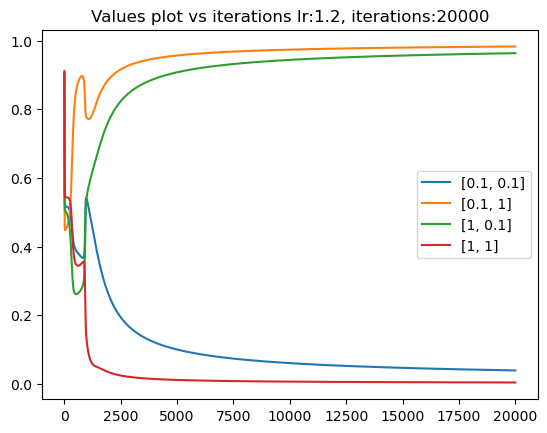

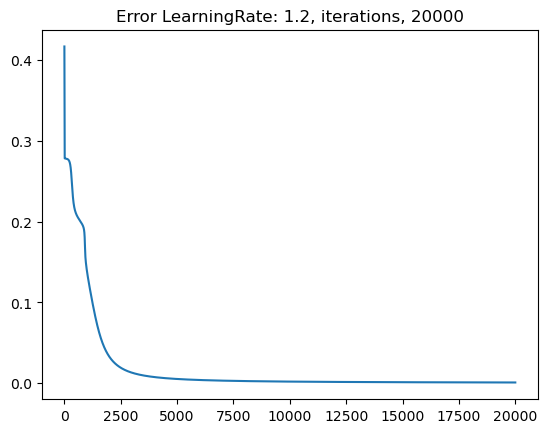

99.92136213644545% accurate


In [387]:
import functools
def plotGraphs(lr, iterations):
    nn = NeuralNetwork(inputCount=2, hiddenlayerWidth=2, hiddenLayerDepth=1, outputCount=1)
    nn.outputLayer[0].weights
    nn.FlushNeuralNetwork()
    errors, nnOutputs = nn.Train(epoches=iterations, inputs=input, outputs=output, learningRate=lr)
    outputDict = {}
    for index in range(len(nnOutputs)):
            if outputDict.keys().__contains__(str(input[index % 4])):
                outputDict[str(input[index % 4])].append(nnOutputs[index])
            else:
                outputDict[str(input[index % 4])] = [nnOutputs[index]]
    for key in outputDict.keys():
        plt.plot(range(1, len(outputDict[key]) + 1), outputDict[key], label=key)
    plt.legend()
    plt.title(f"Values plot vs iterations lr:{lr}, iterations:{iterations}")
    plt.savefig(f"Figures/Values/Values plot vs iterations lr:{lr}, iterations:{iterations}.jpg")
    plt.show()
    errors = np.array(errors)
    plt.plot(range(1, len(errors) +1), errors)
    plt.title(f"Error LearningRate: {lr}, iterations, {iterations}")
    plt.savefig(f"Figures/Errors/Error LearningRate: {lr}, iterations, {iterations}.jpg")
    plt.show()
    finalError = nn.GetError(inputs=input, outputs=output)
    finalError = functools.reduce(lambda a, b: a + b, finalError)
    return finalError/len(input)

finalError = plotGraphs(1.2, 20000)
print(f"{(1 - finalError) * 100}% accurate")

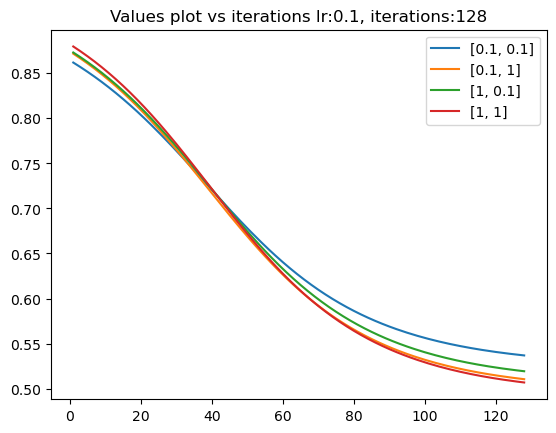

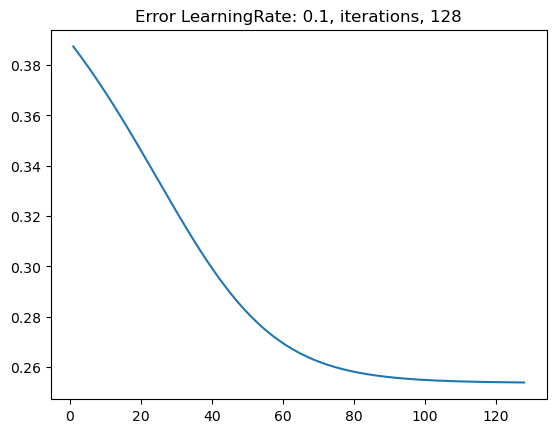

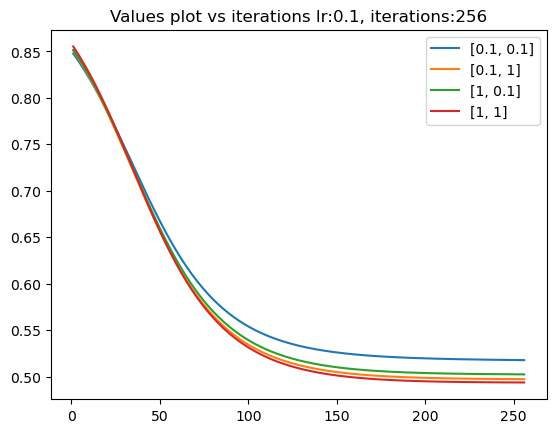

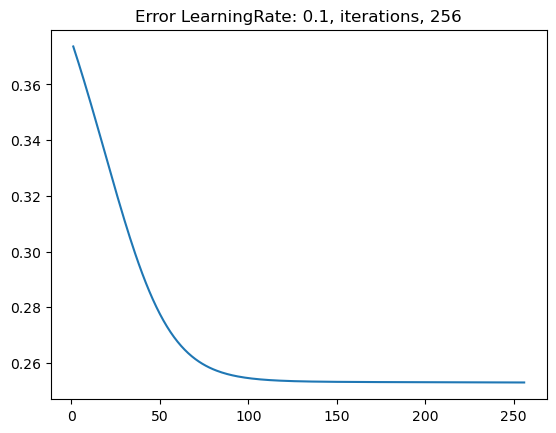

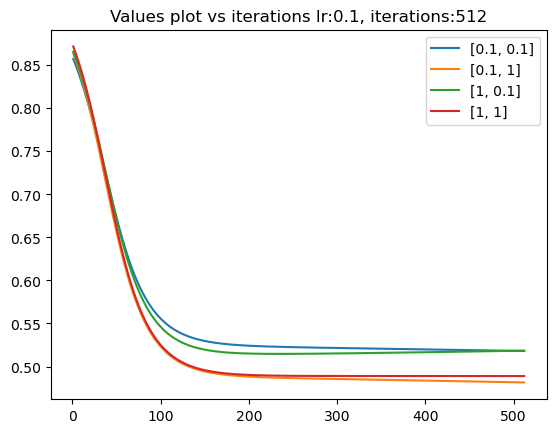

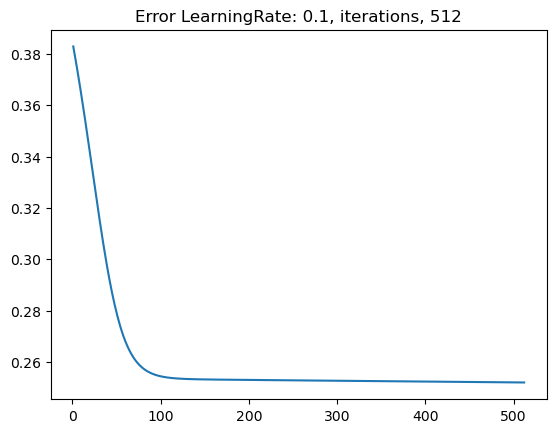

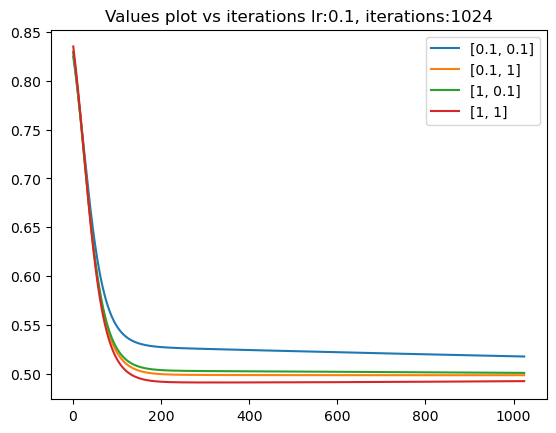

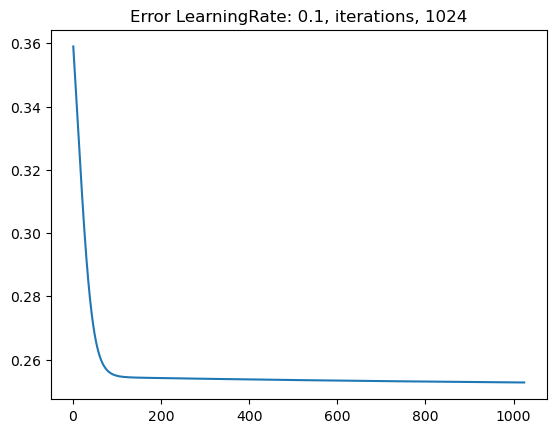

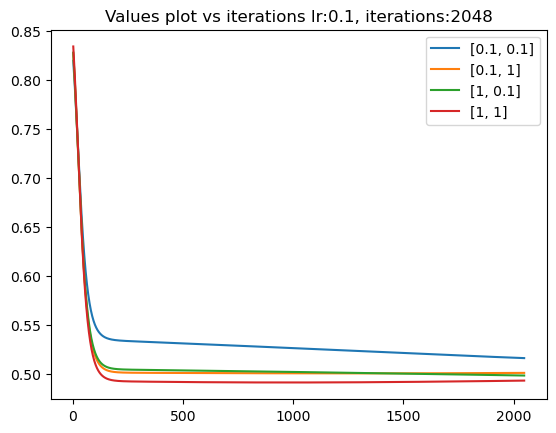

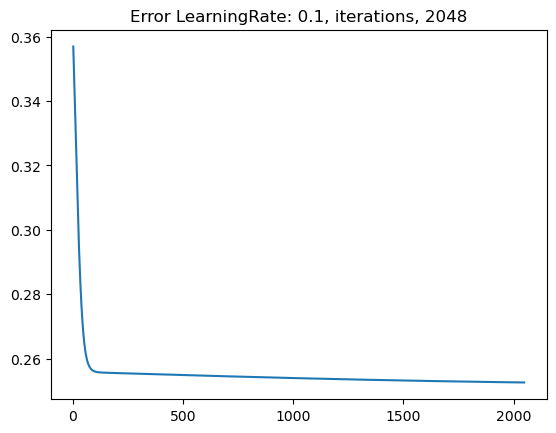

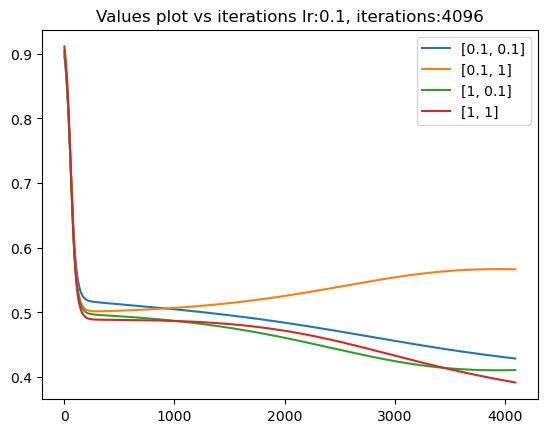

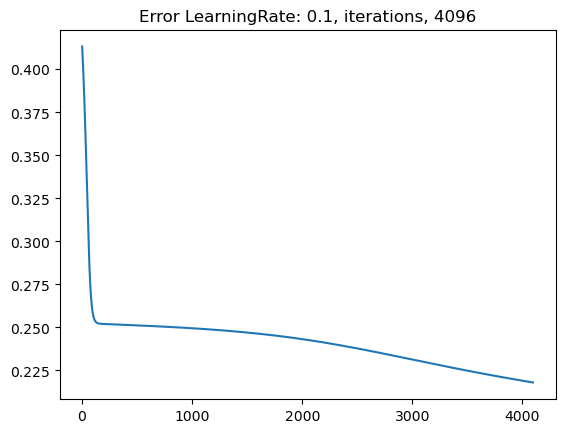

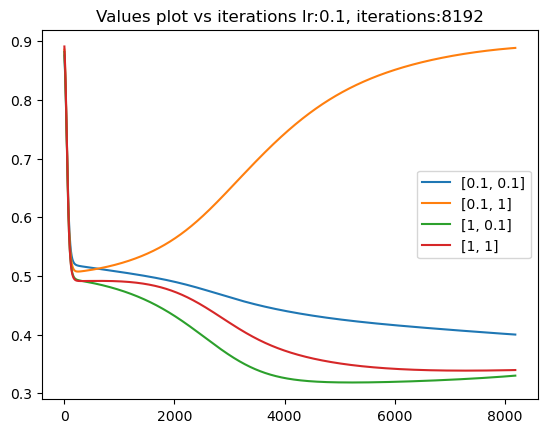

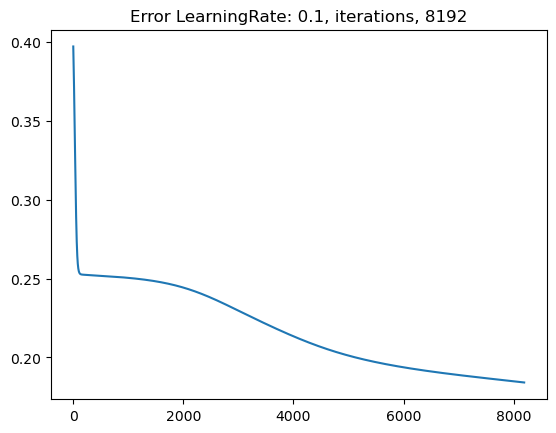

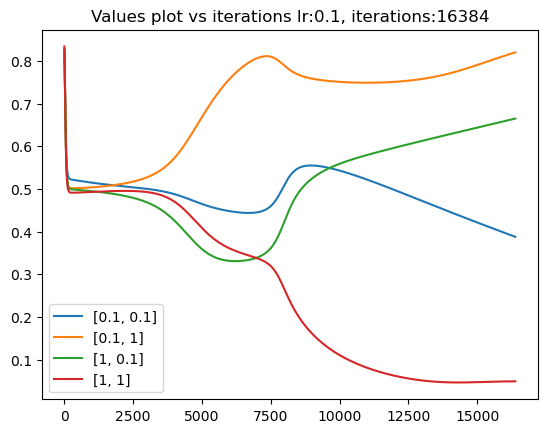

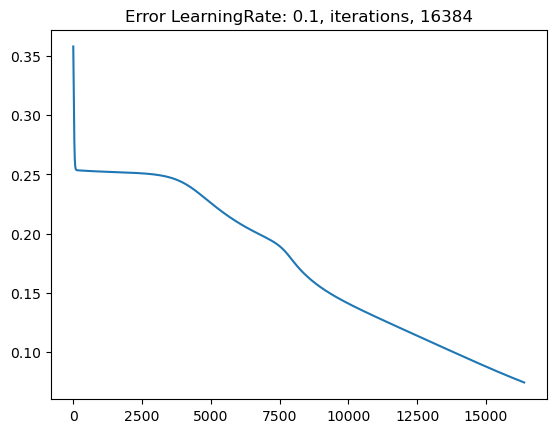

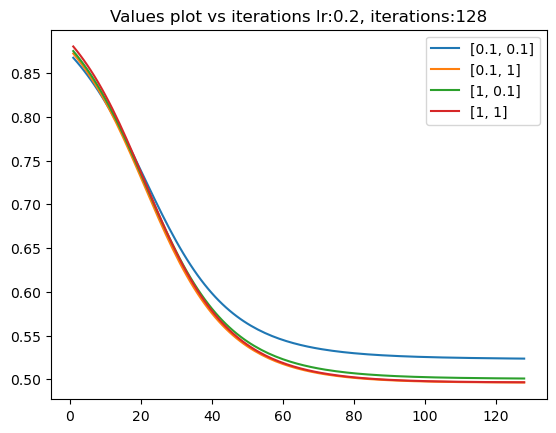

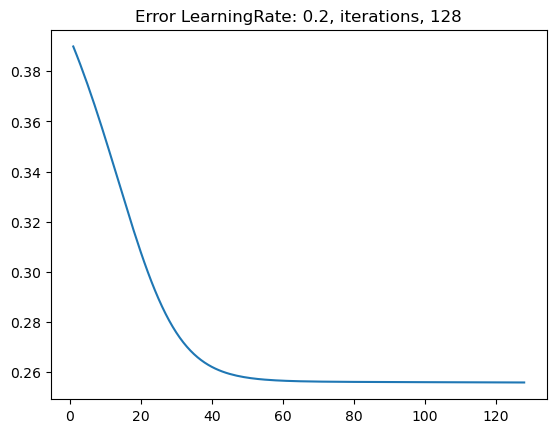

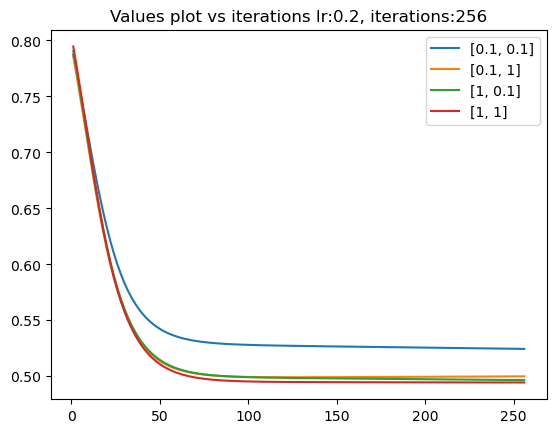

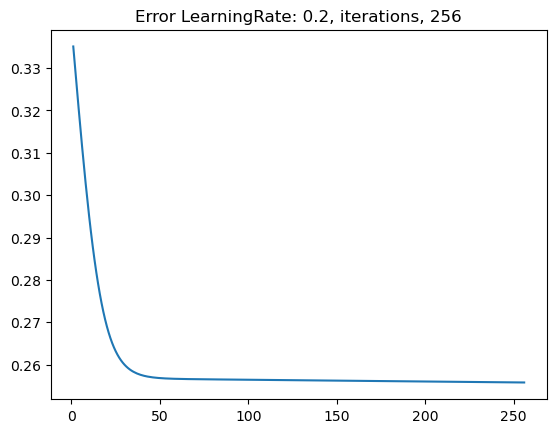

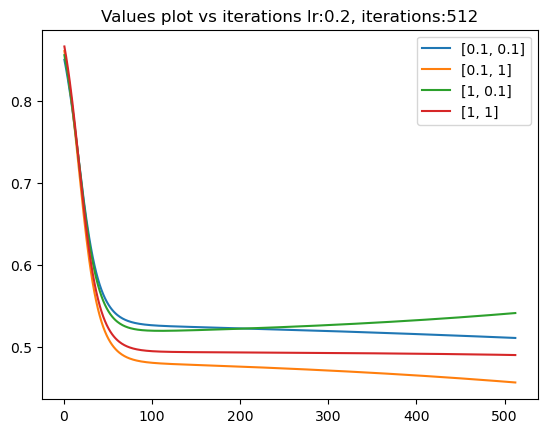

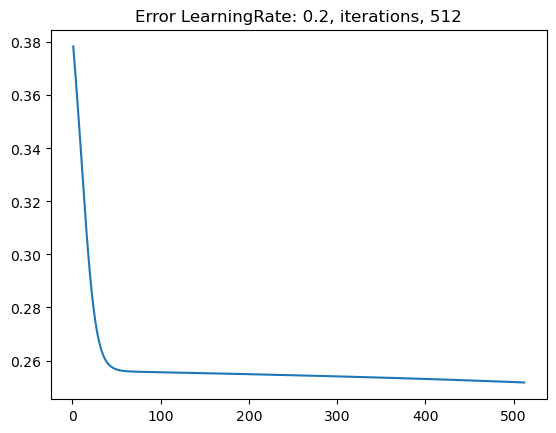

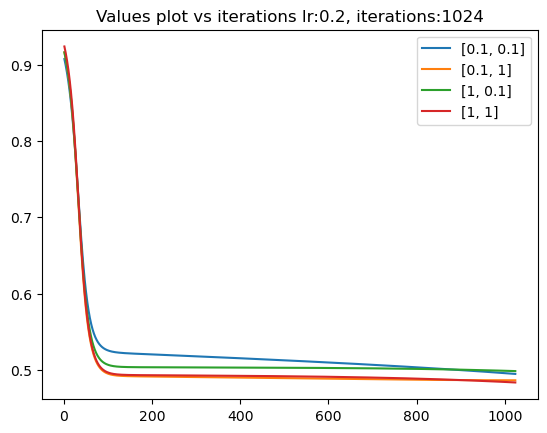

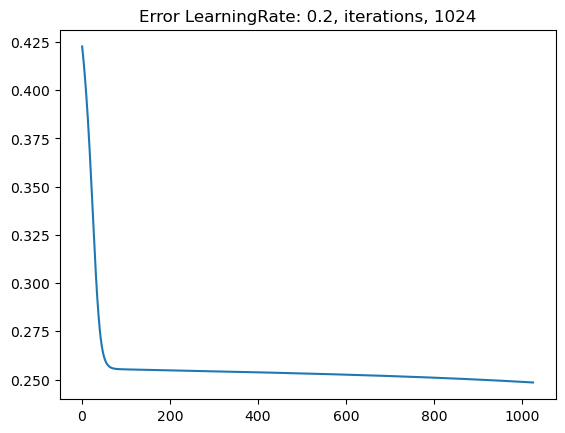

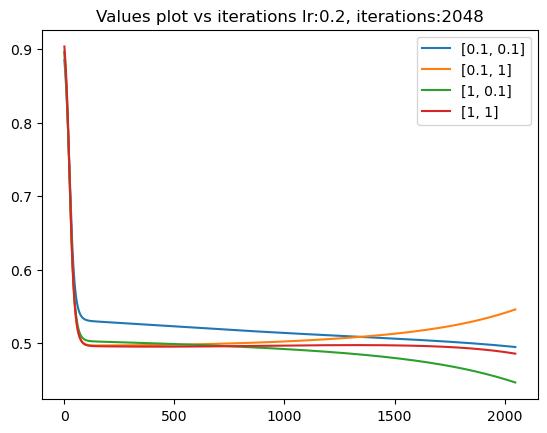

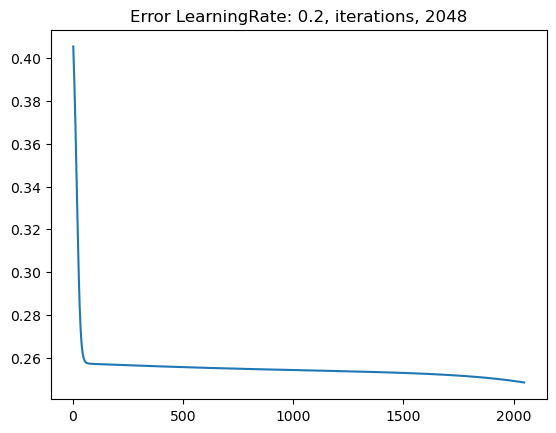

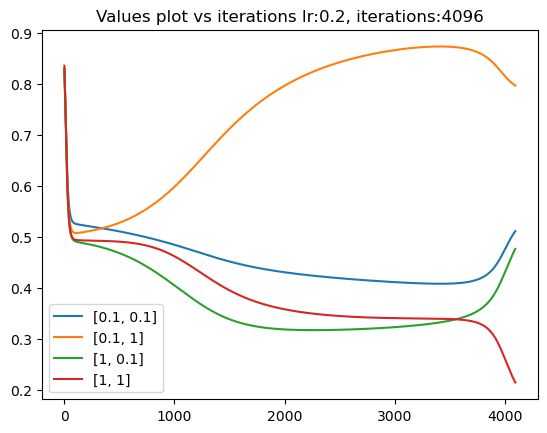

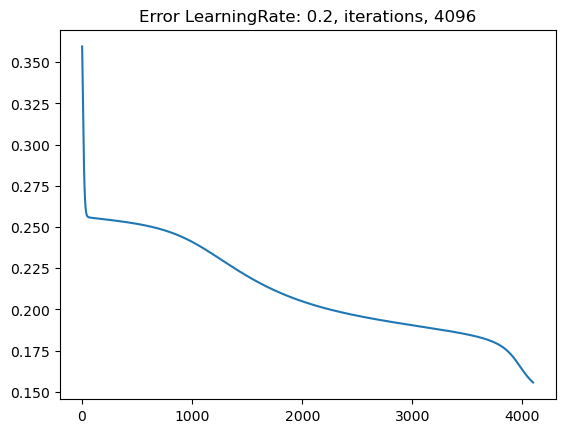

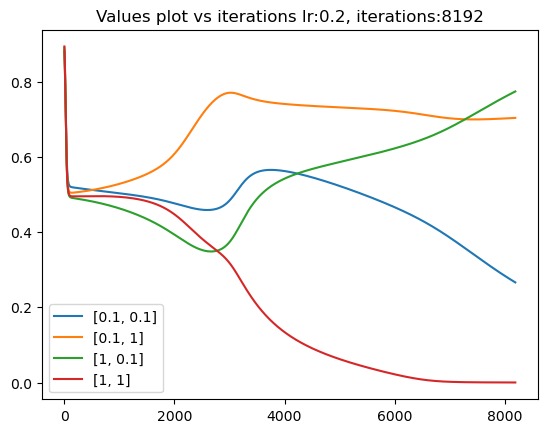

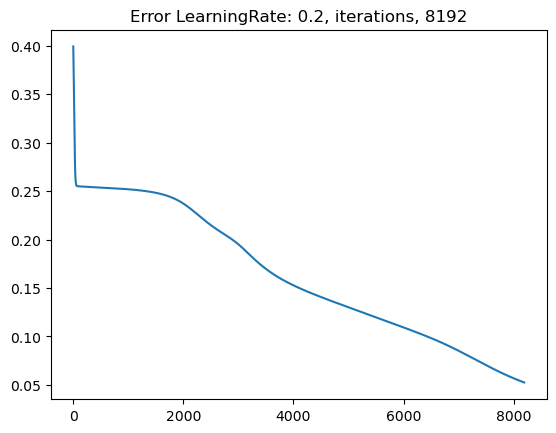

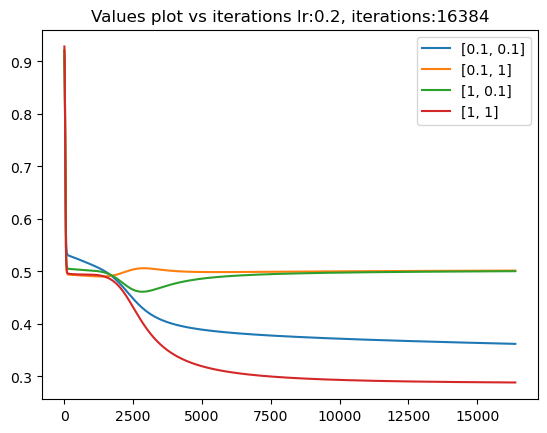

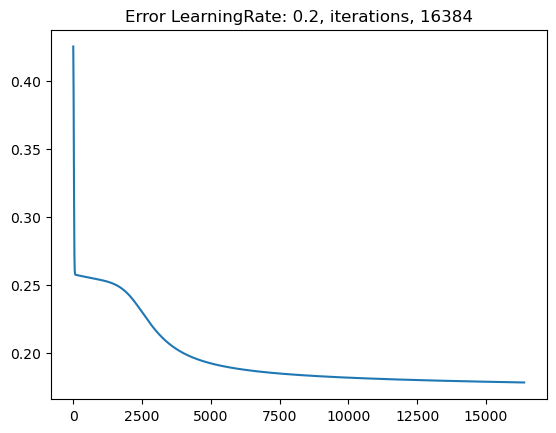

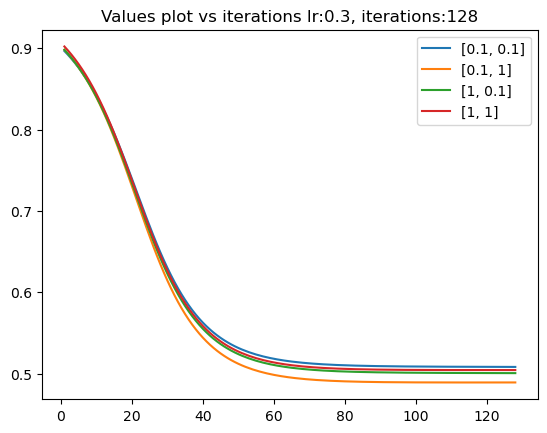

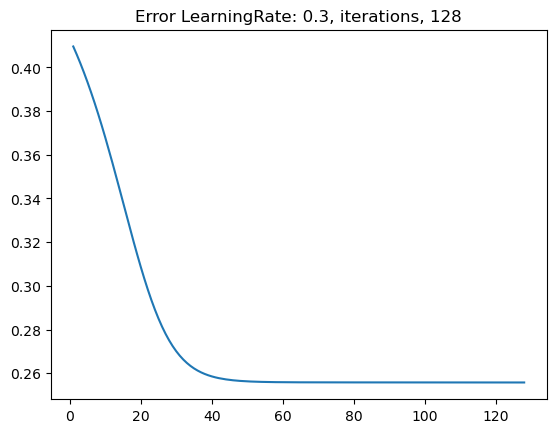

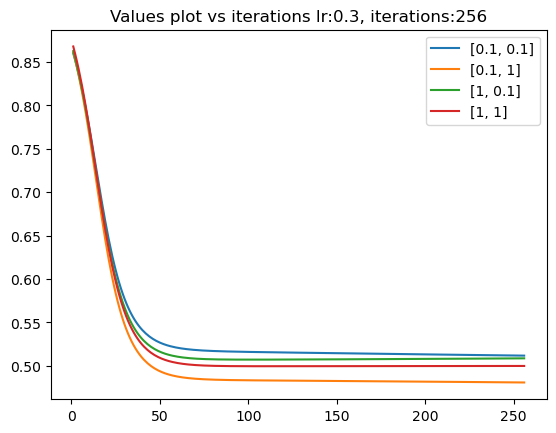

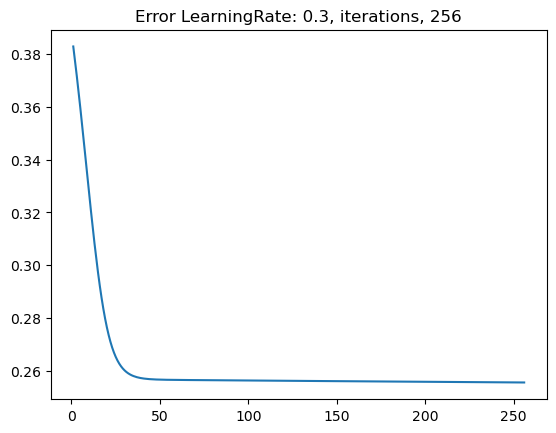

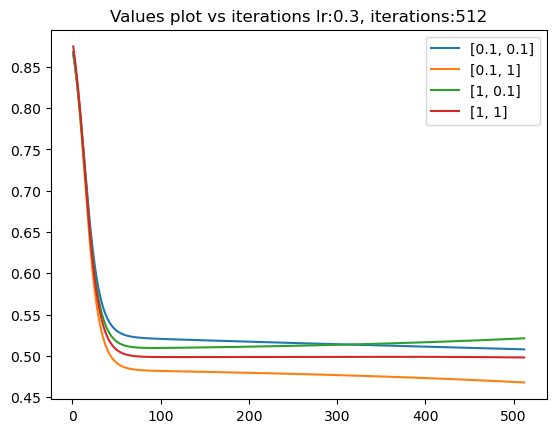

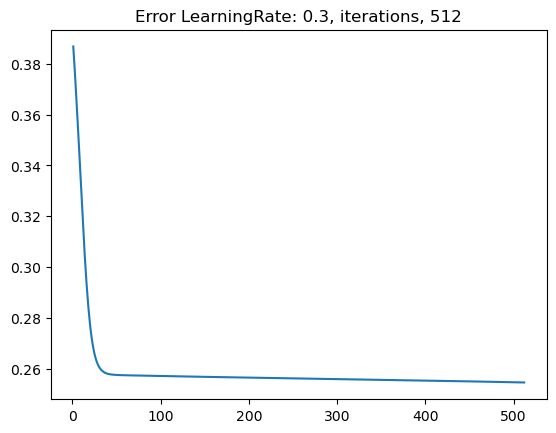

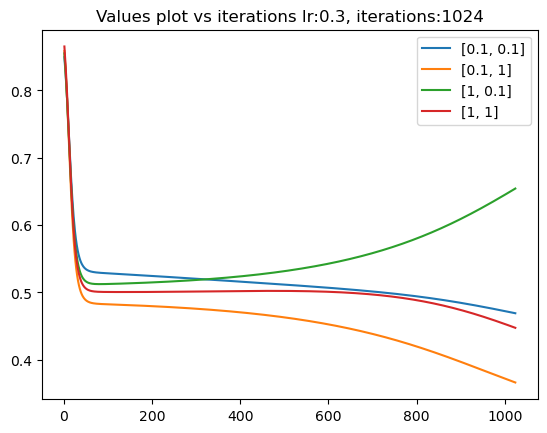

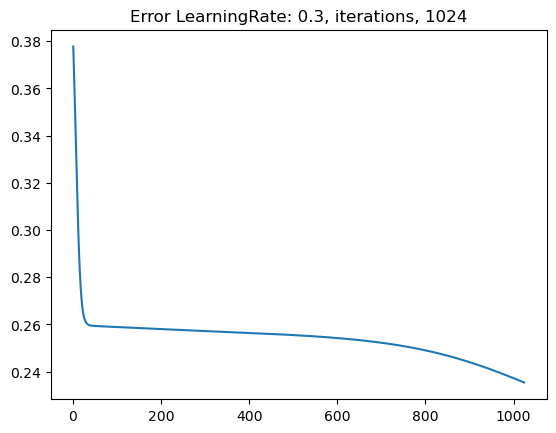

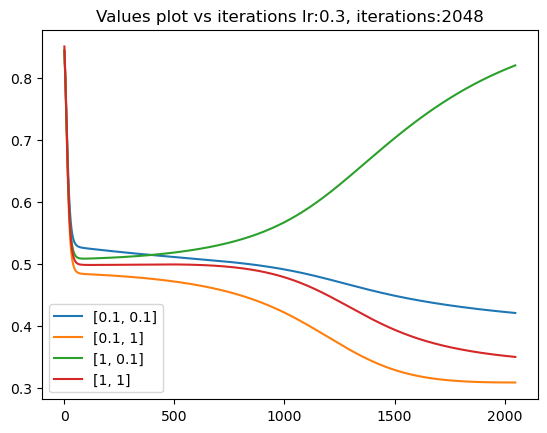

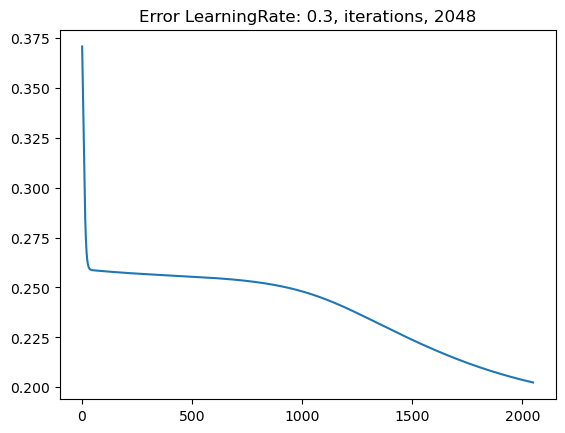

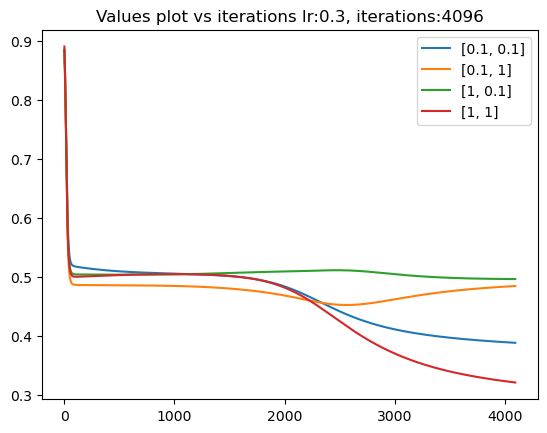

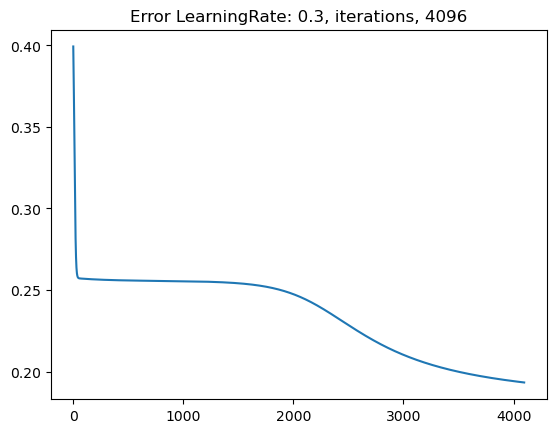

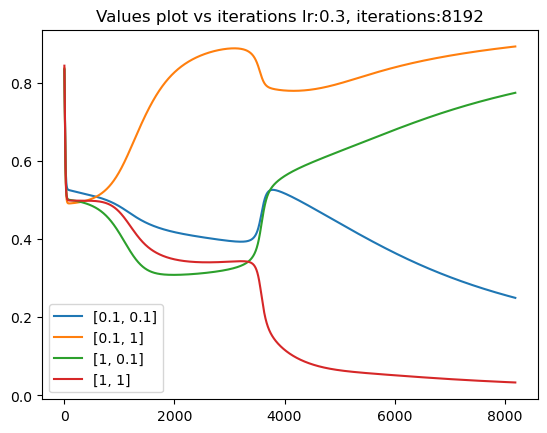

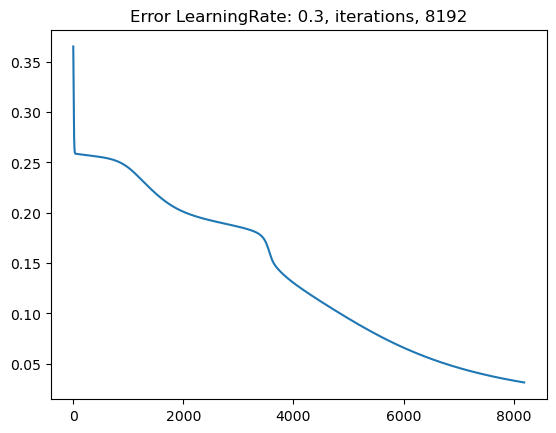

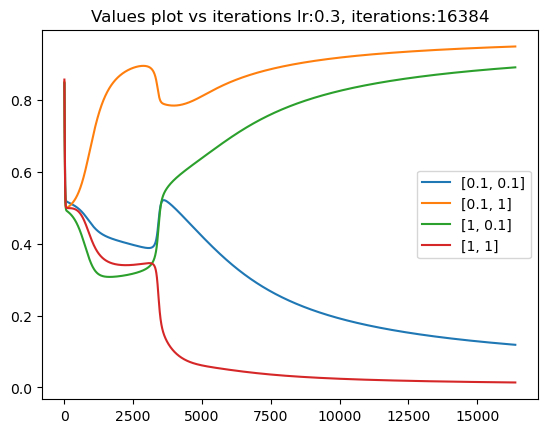

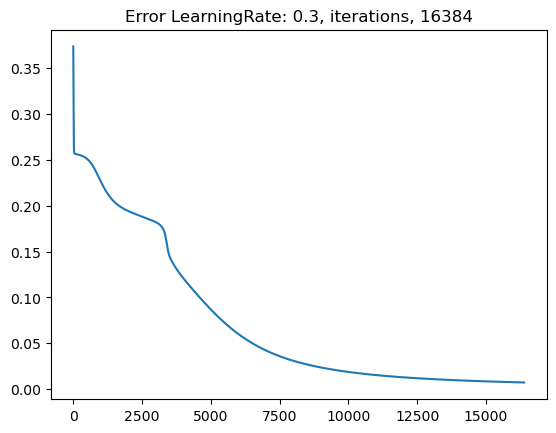

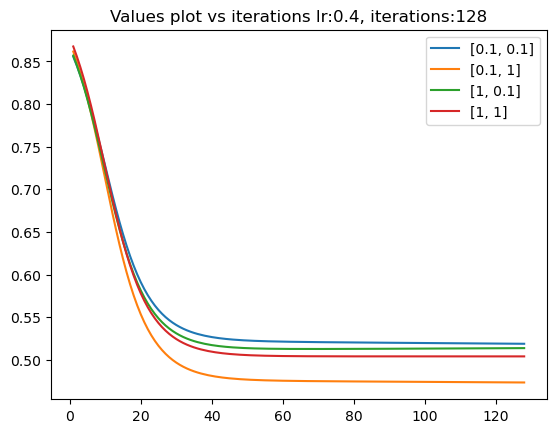

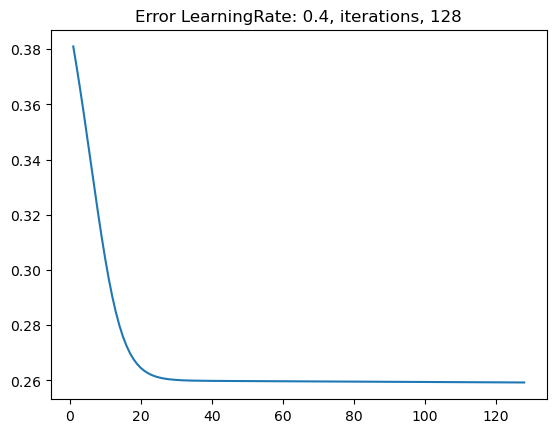

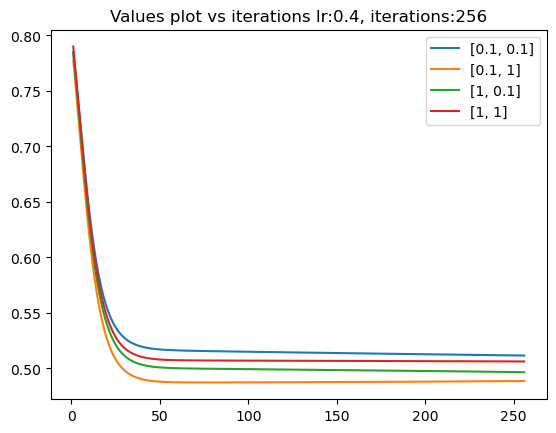

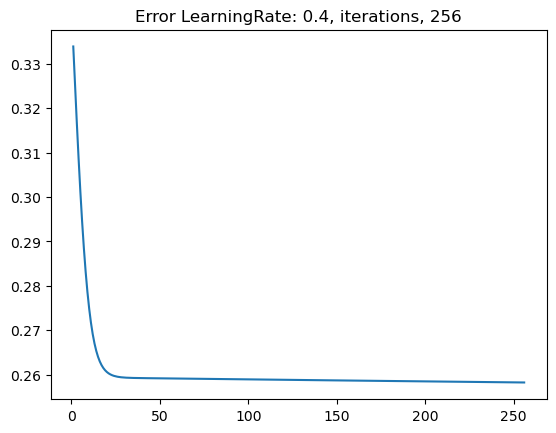

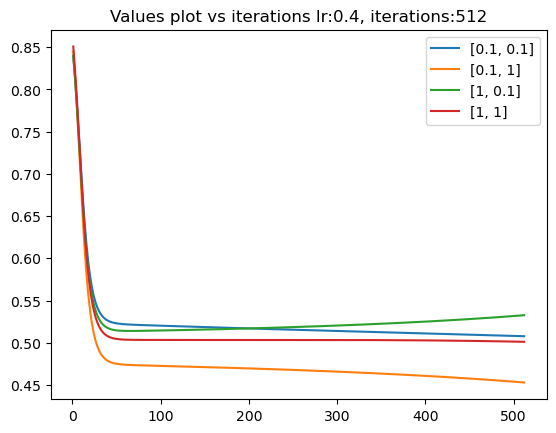

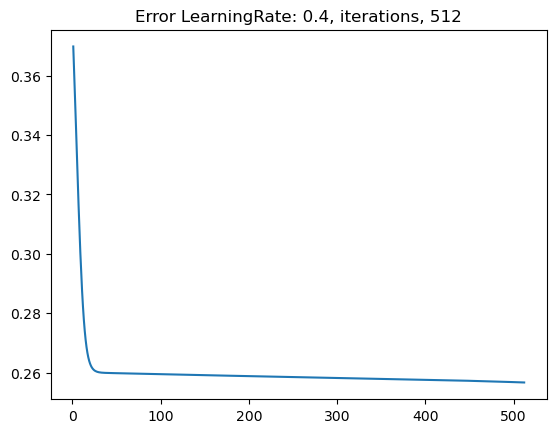

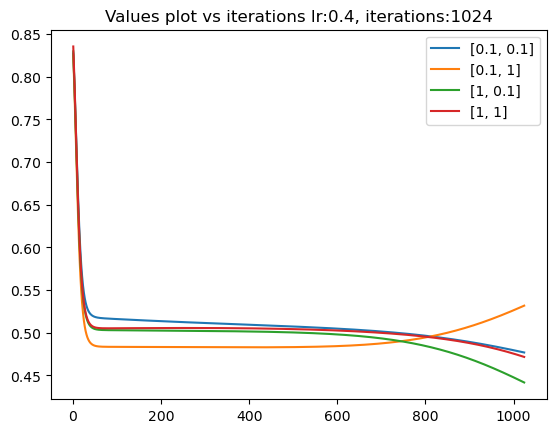

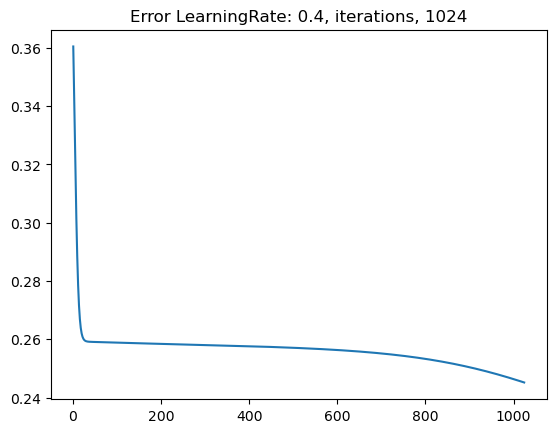

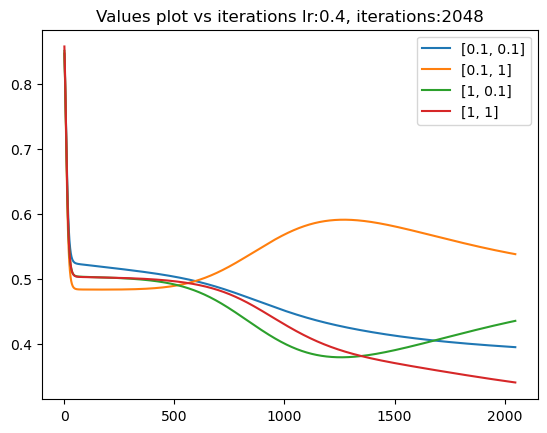

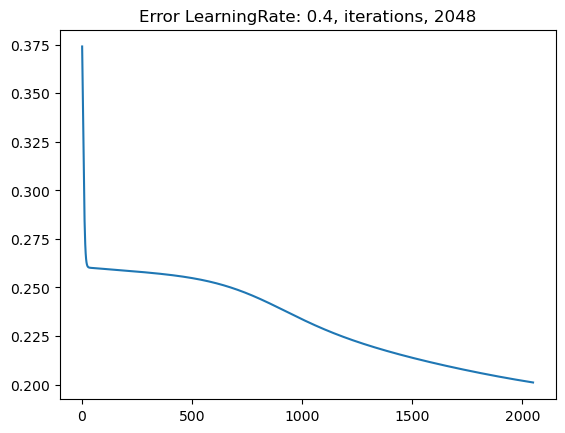

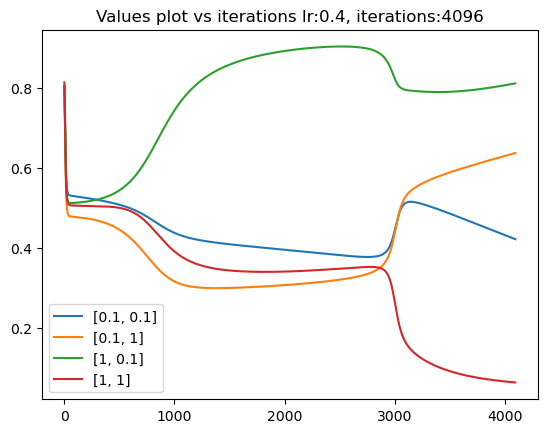

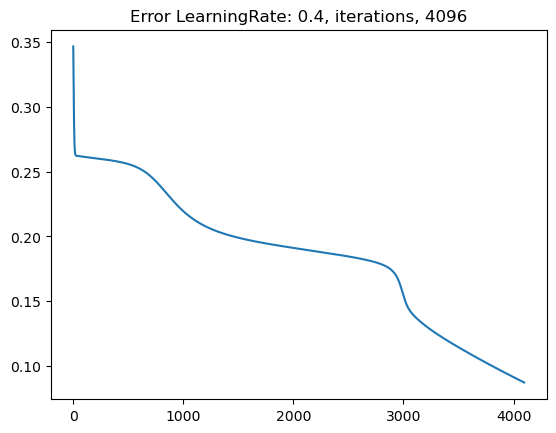

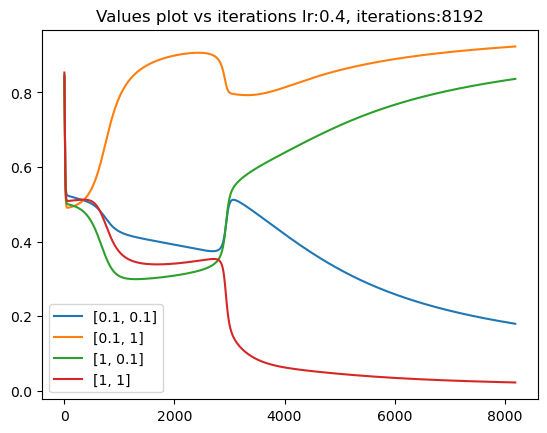

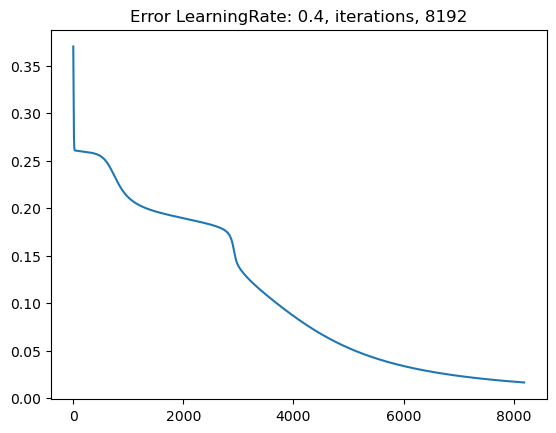

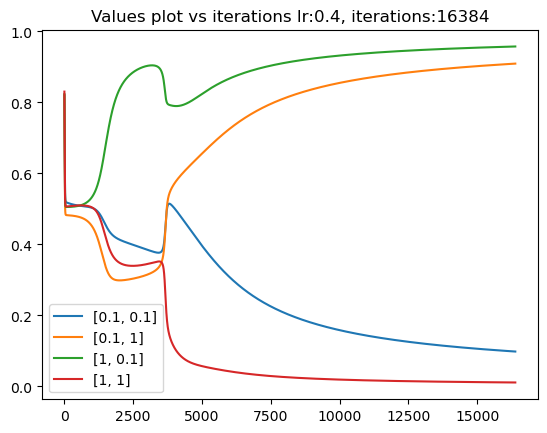

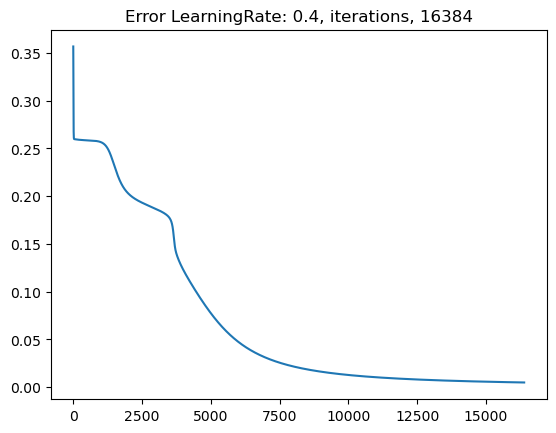

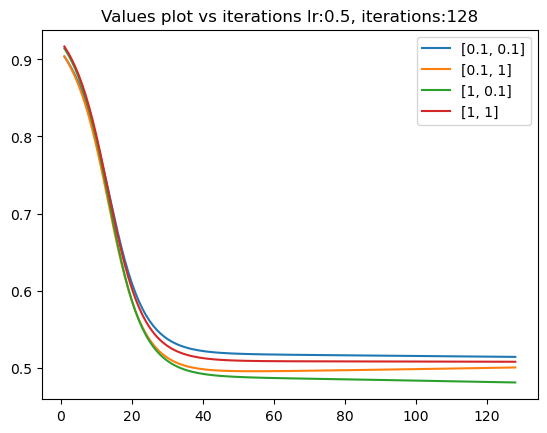

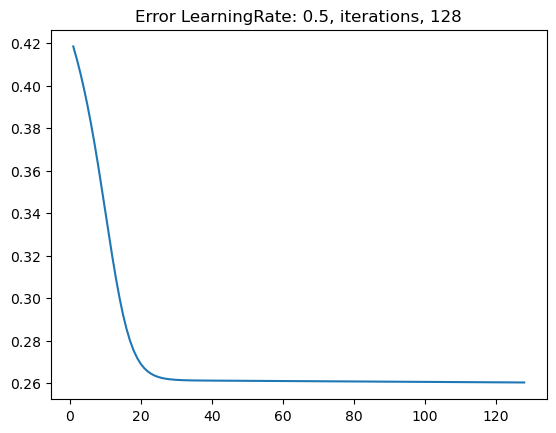

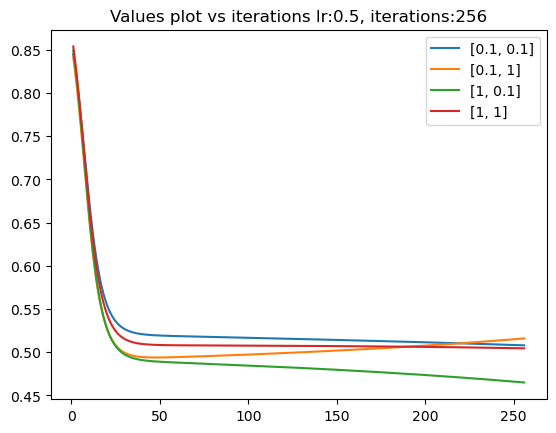

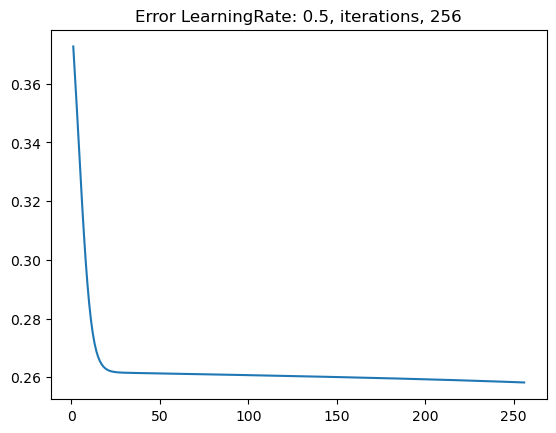

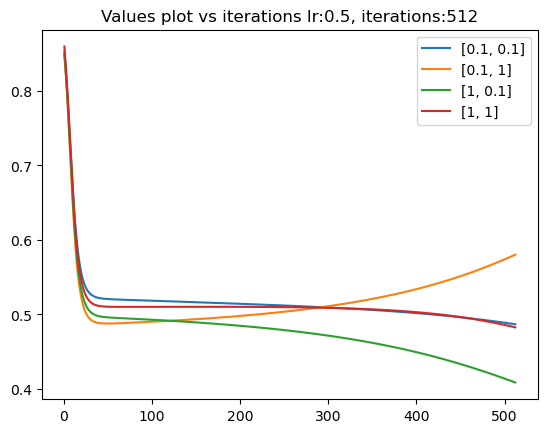

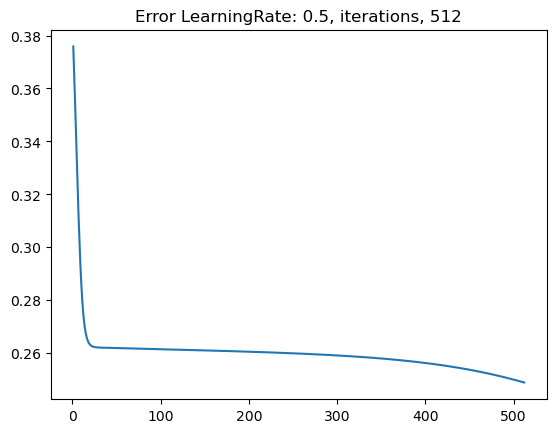

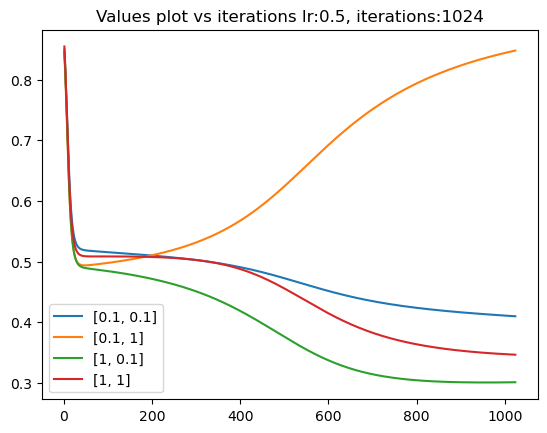

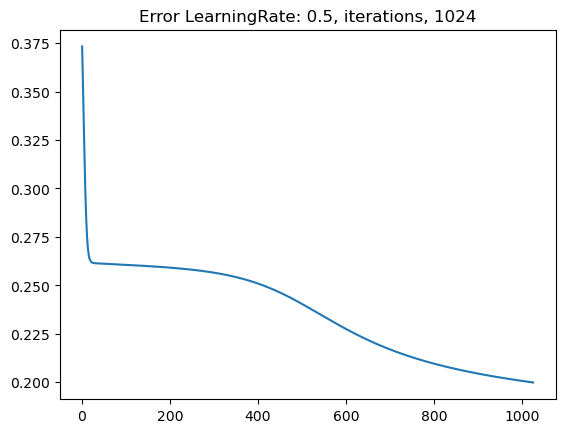

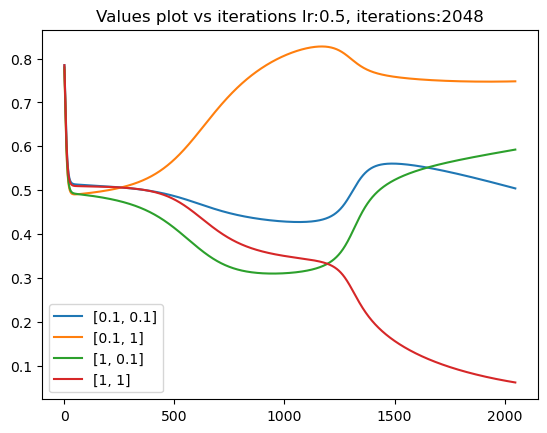

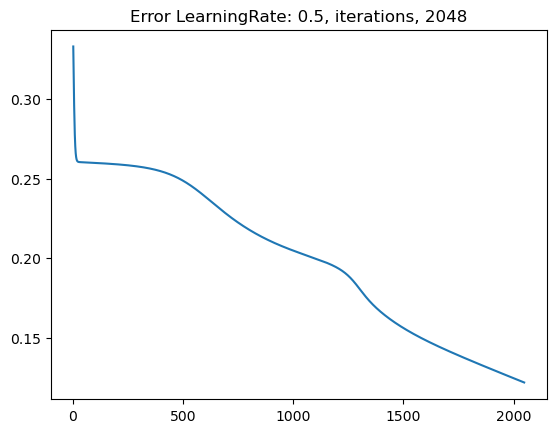

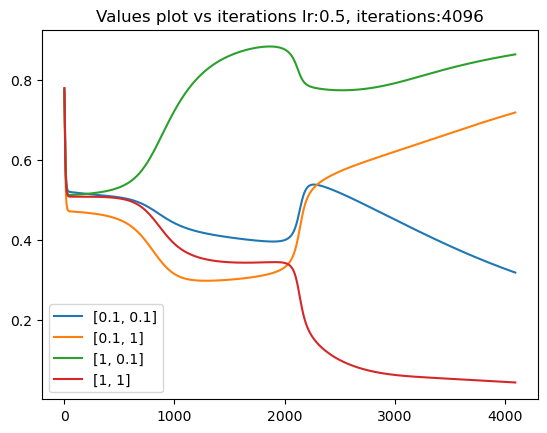

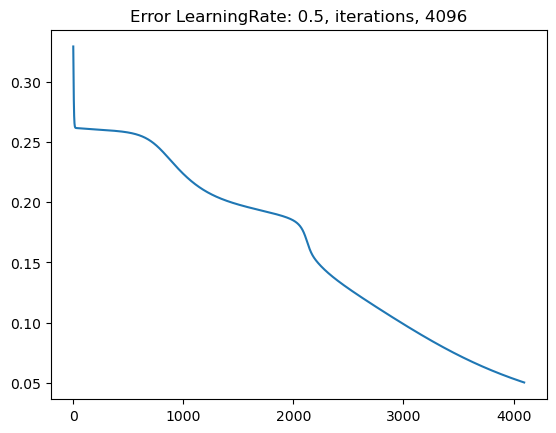

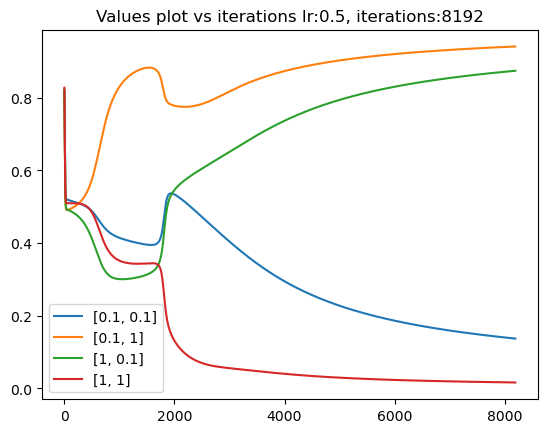

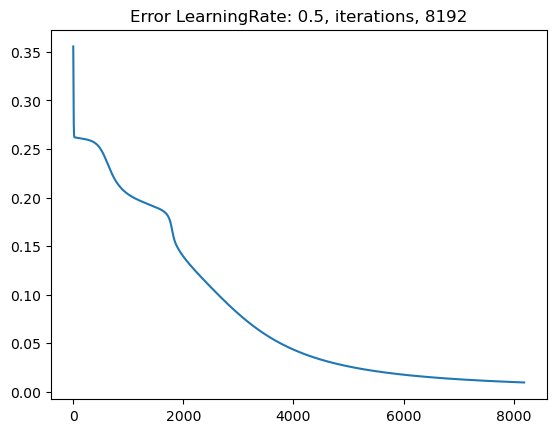

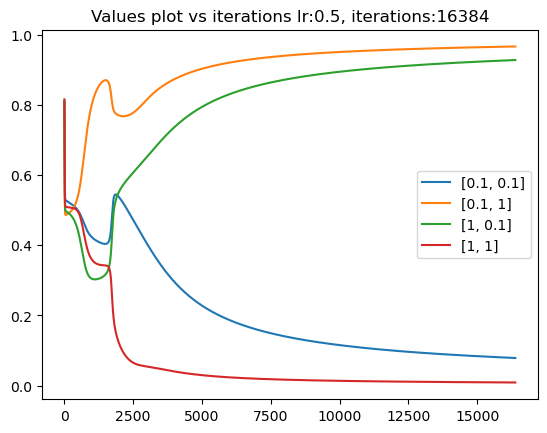

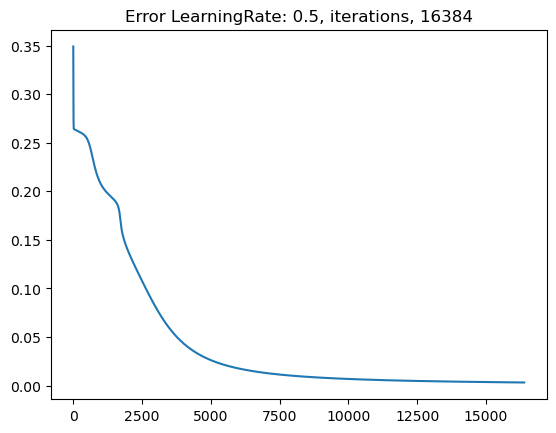

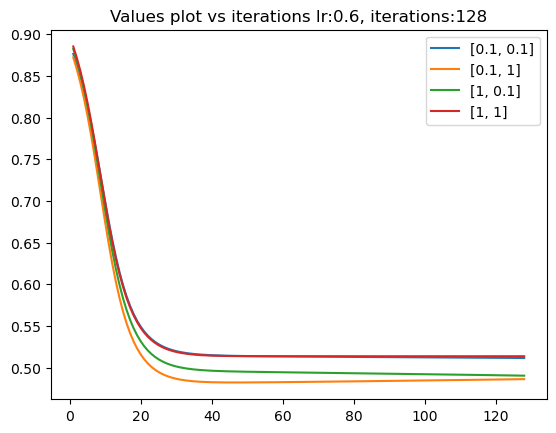

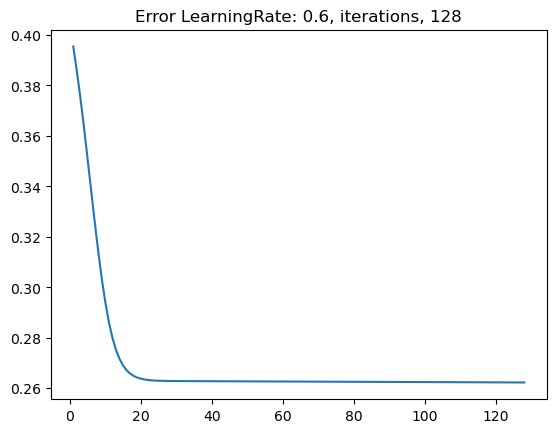

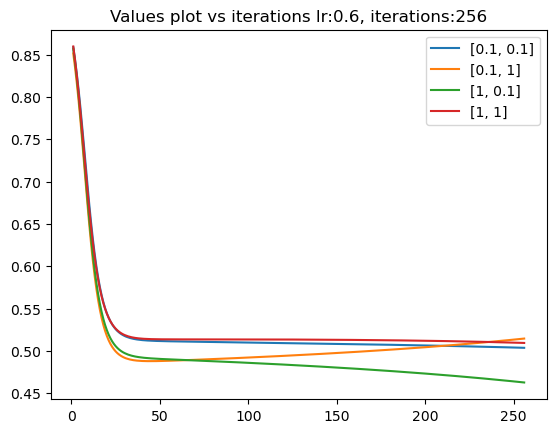

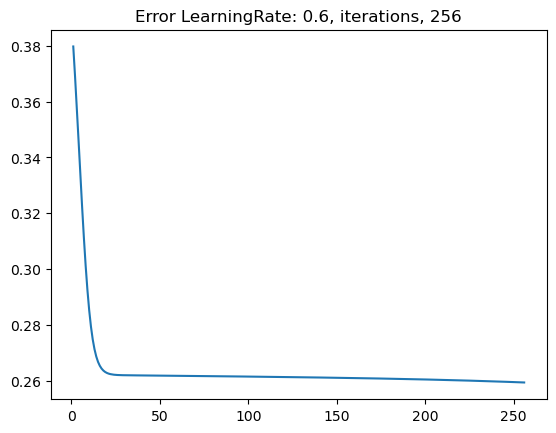

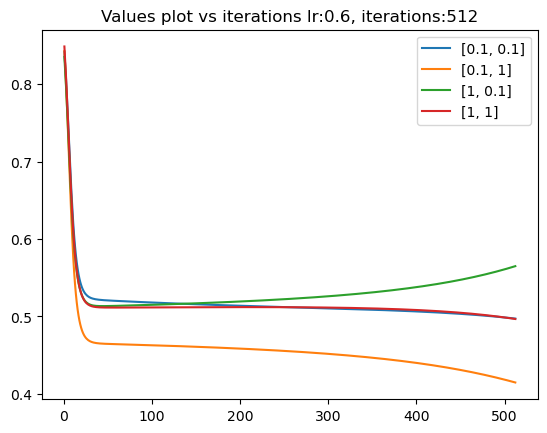

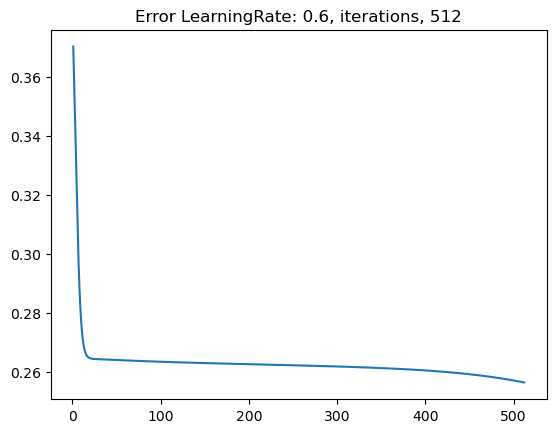

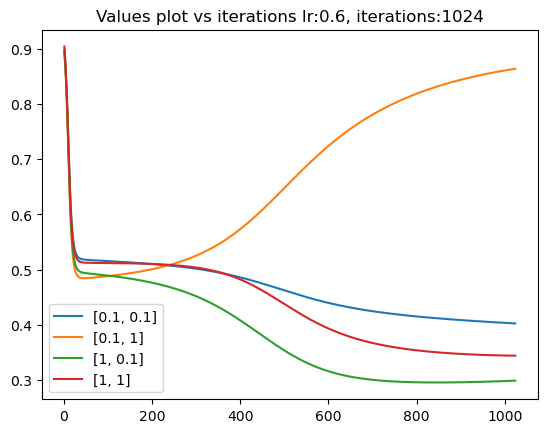

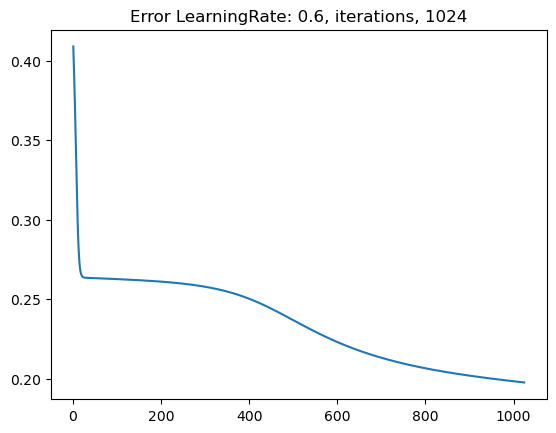

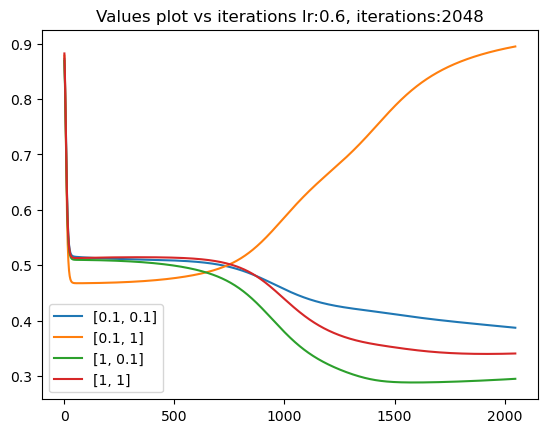

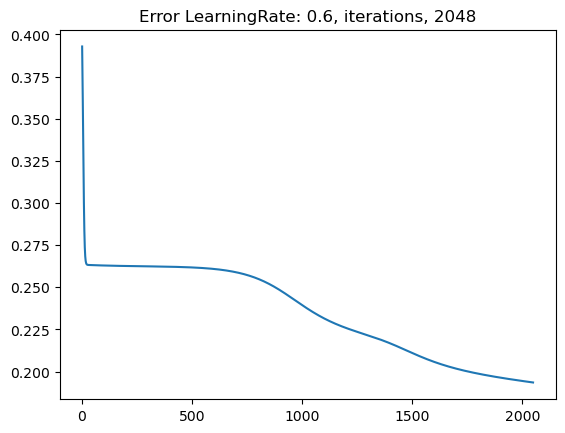

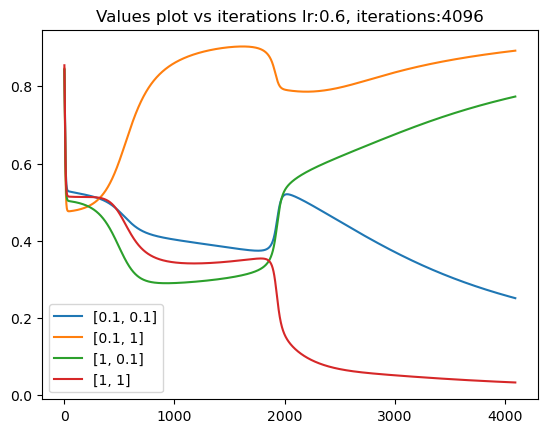

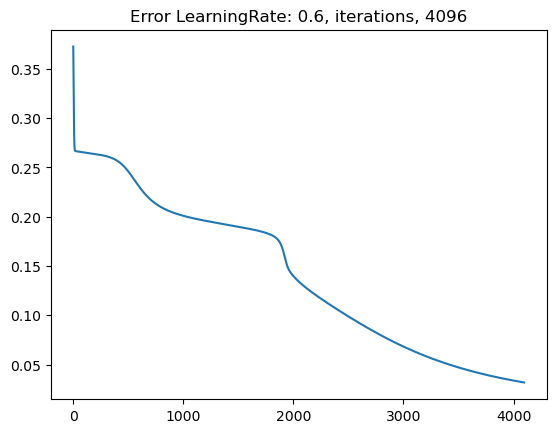

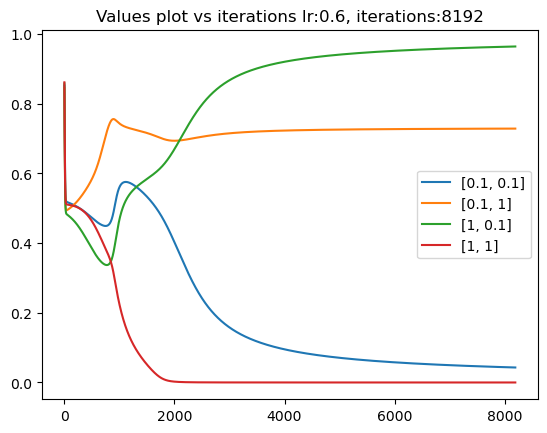

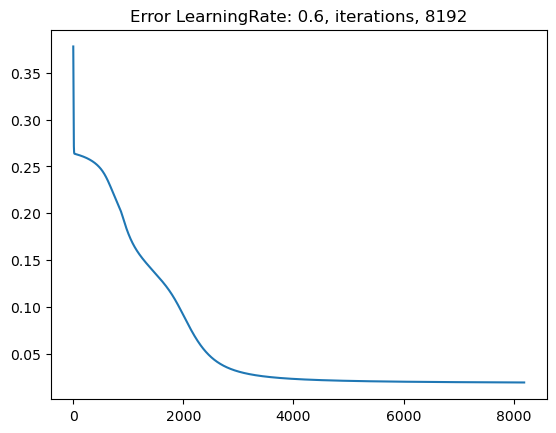

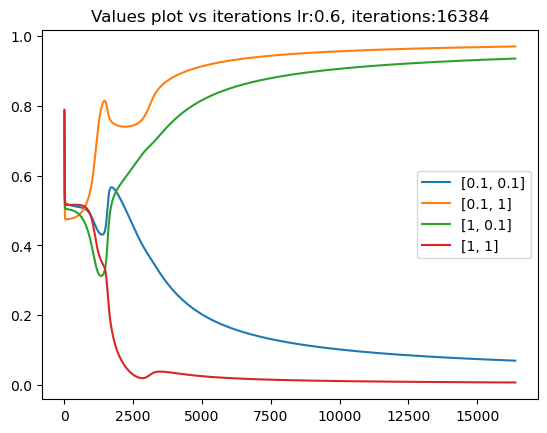

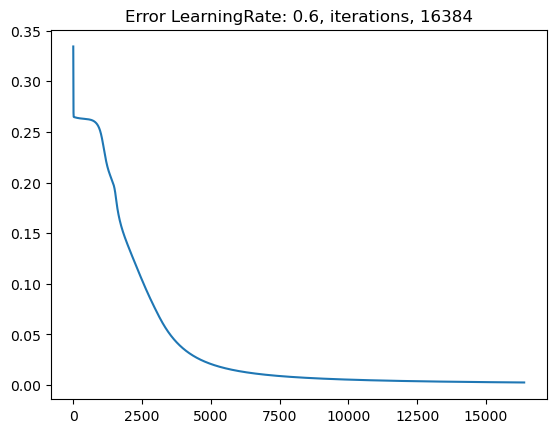

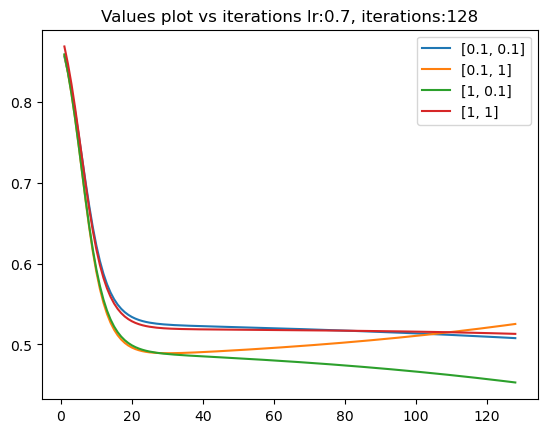

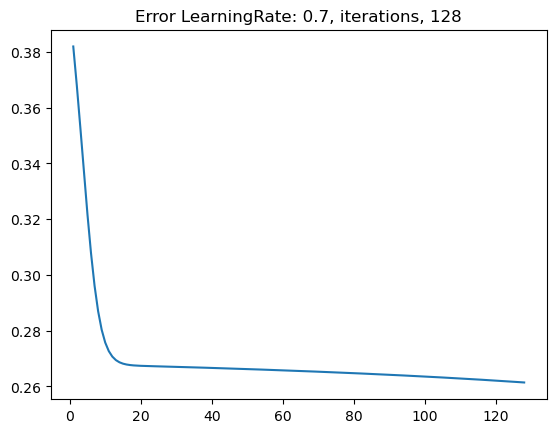

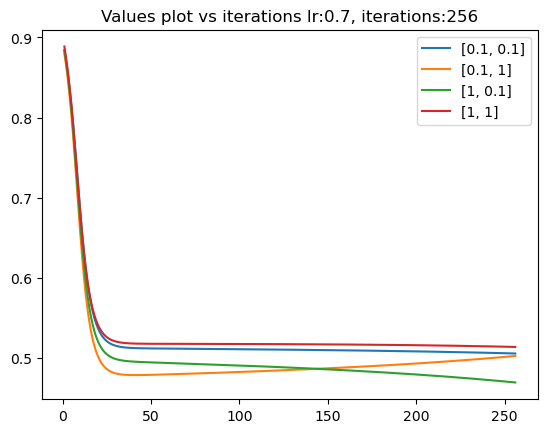

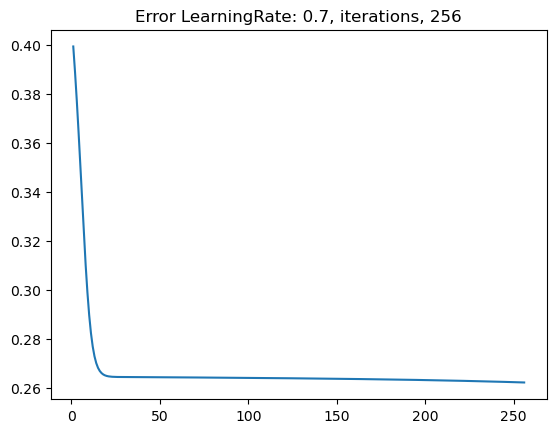

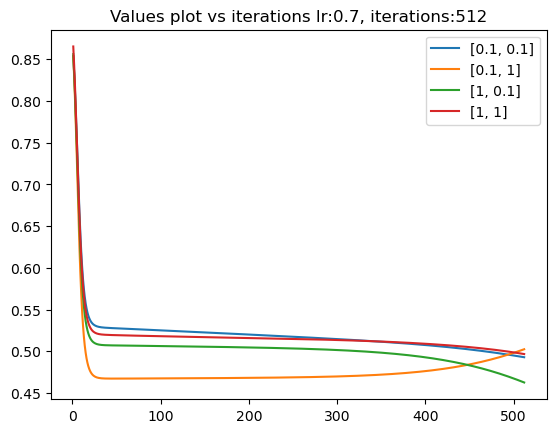

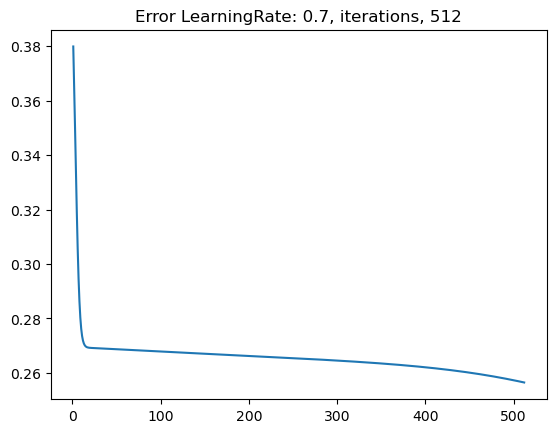

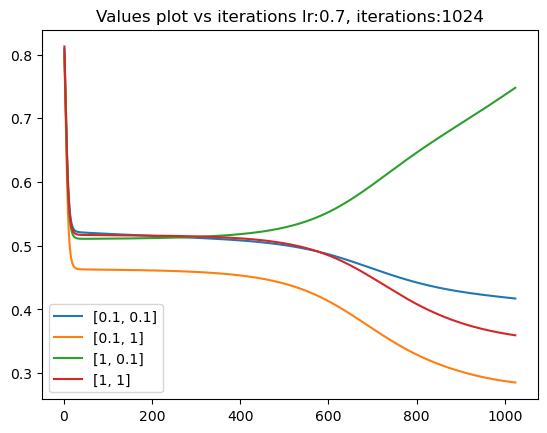

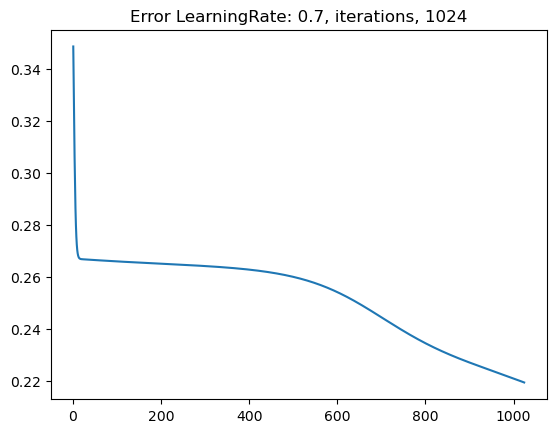

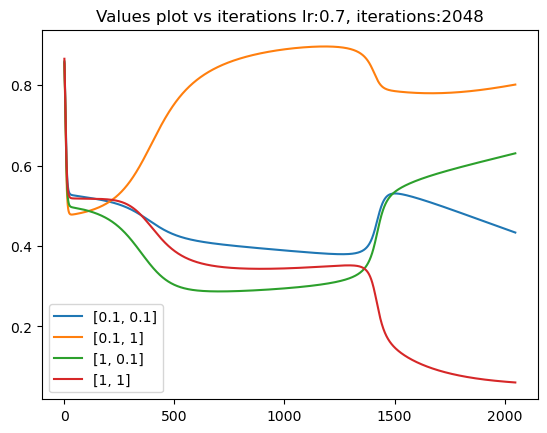

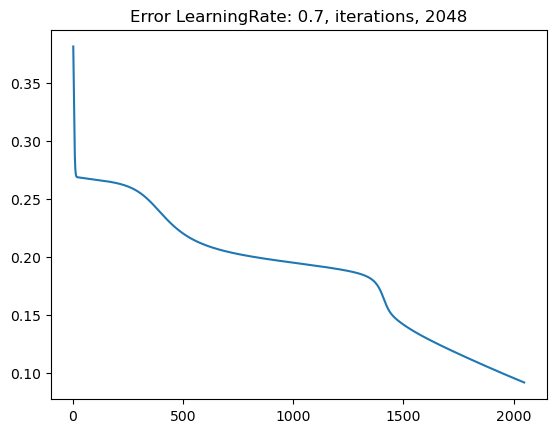

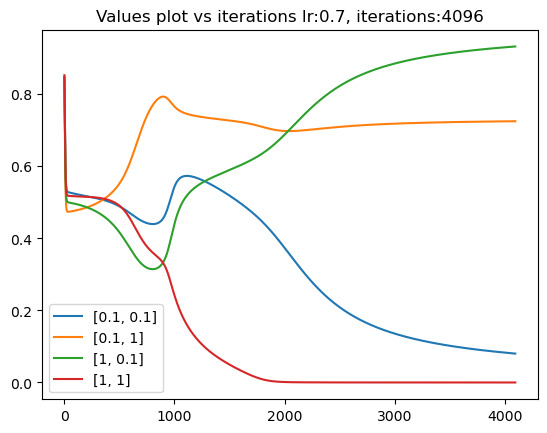

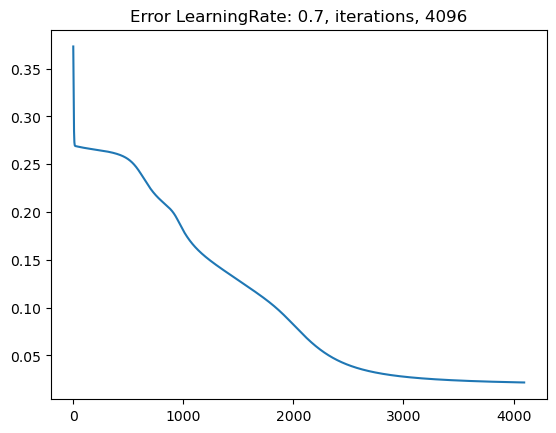

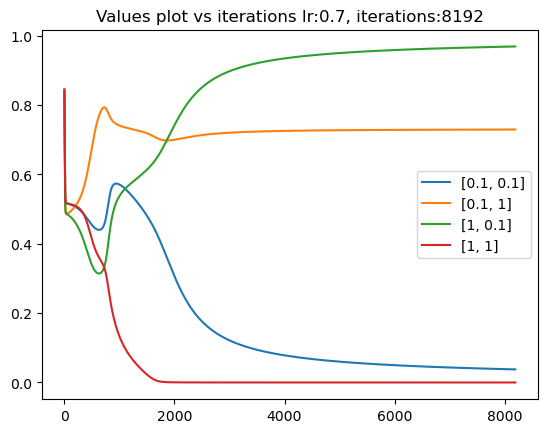

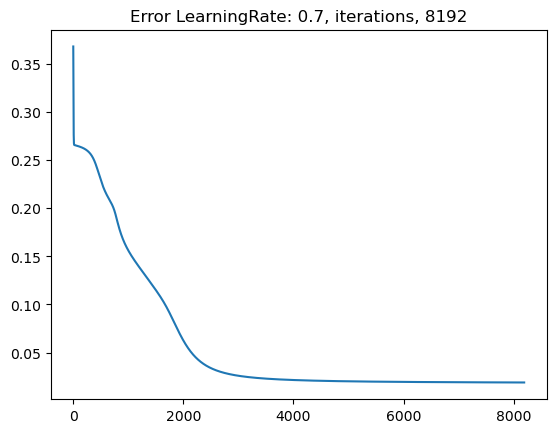

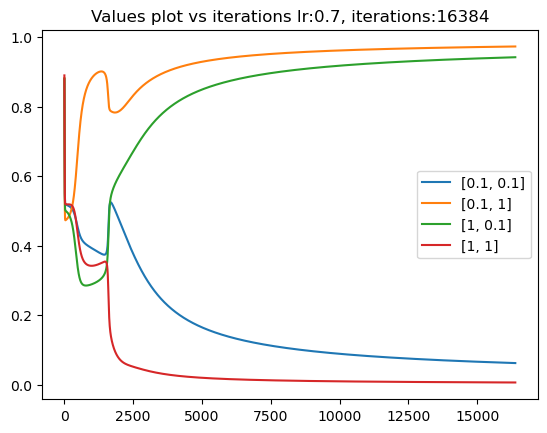

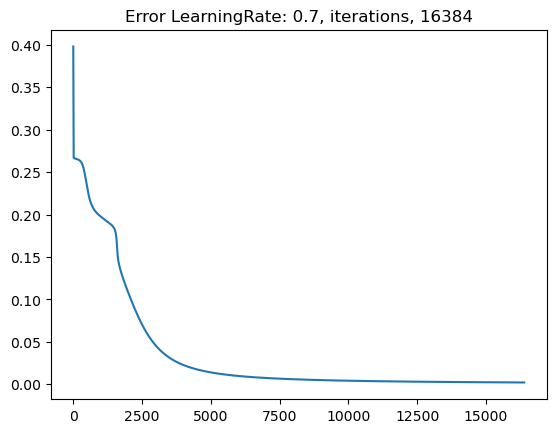

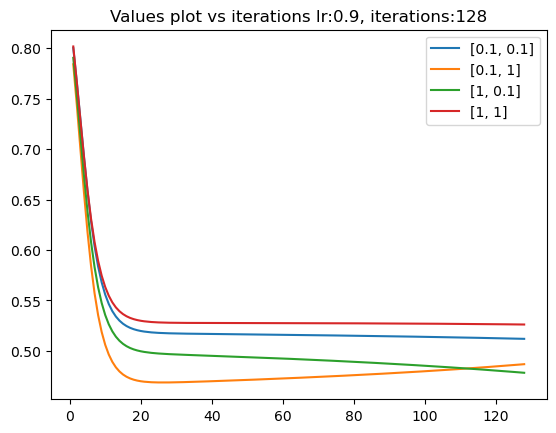

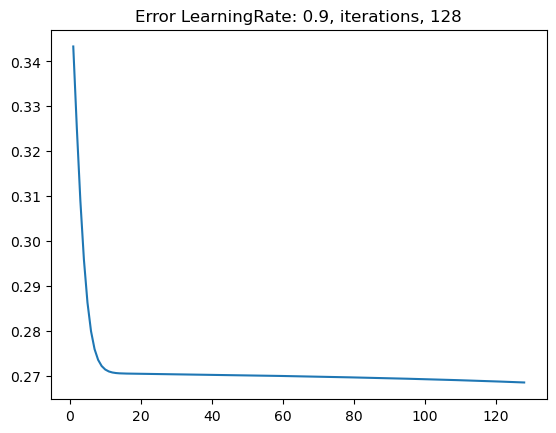

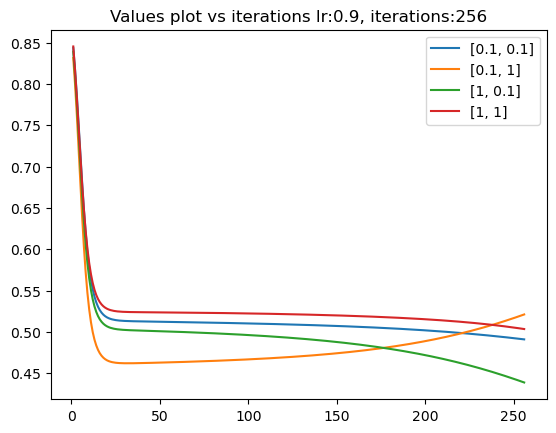

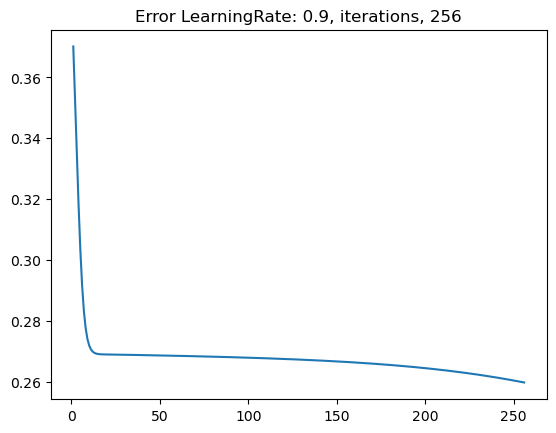

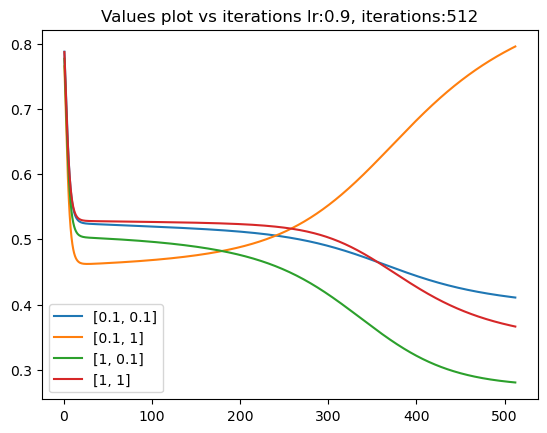

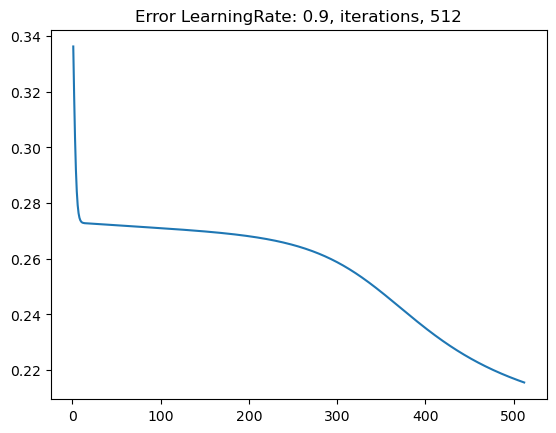

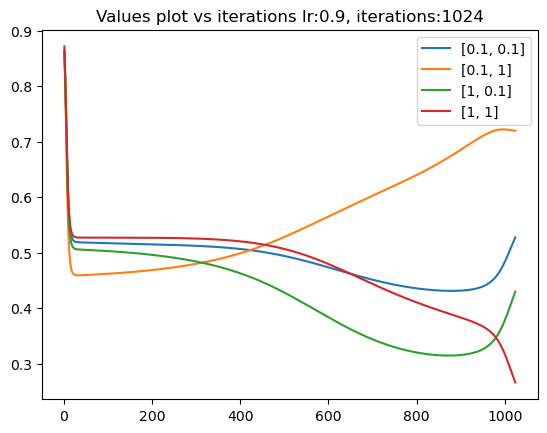

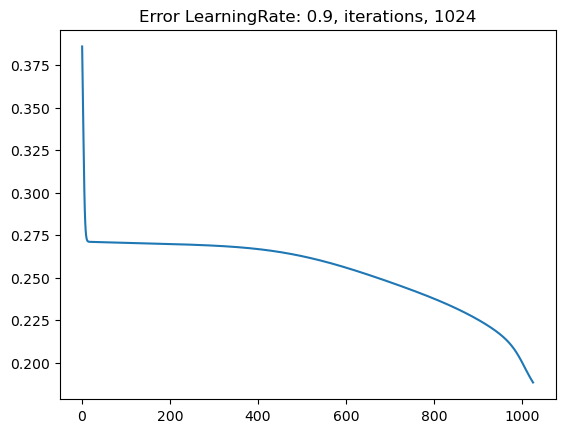

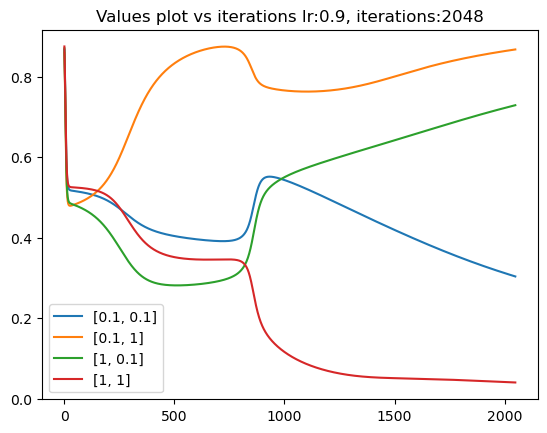

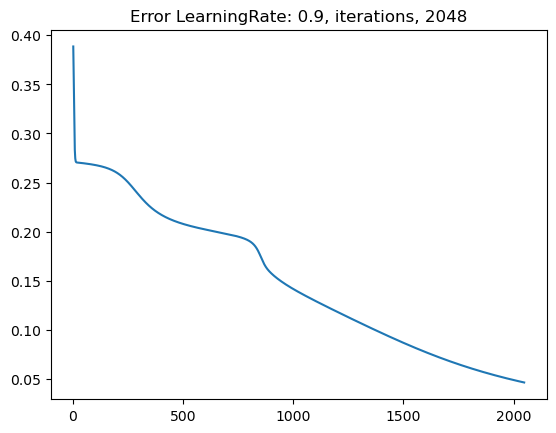

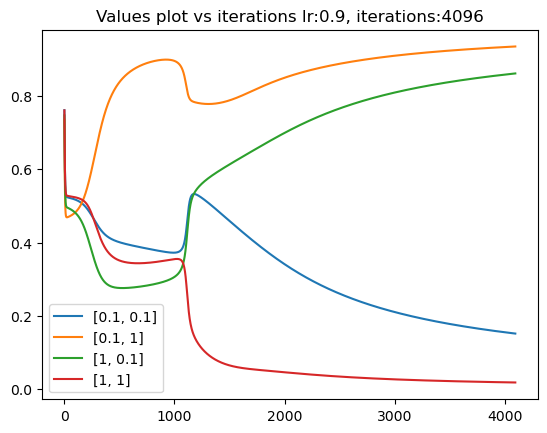

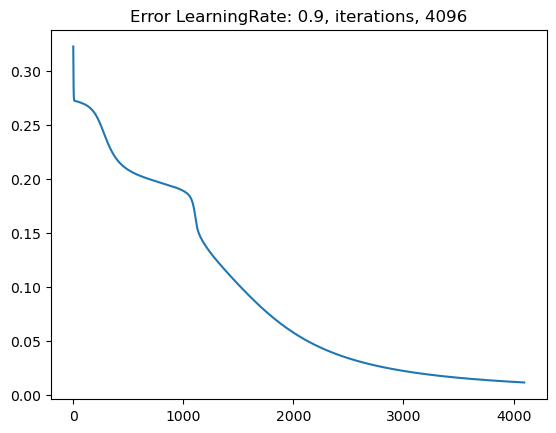

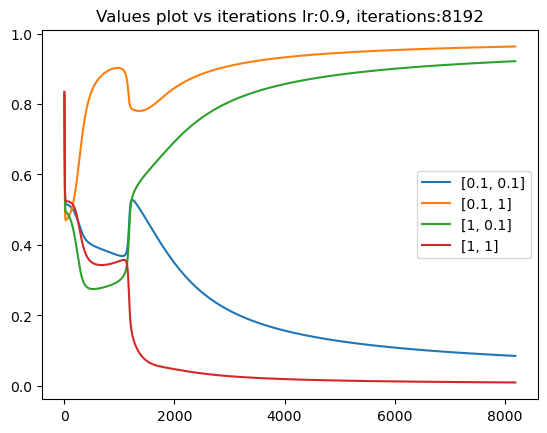

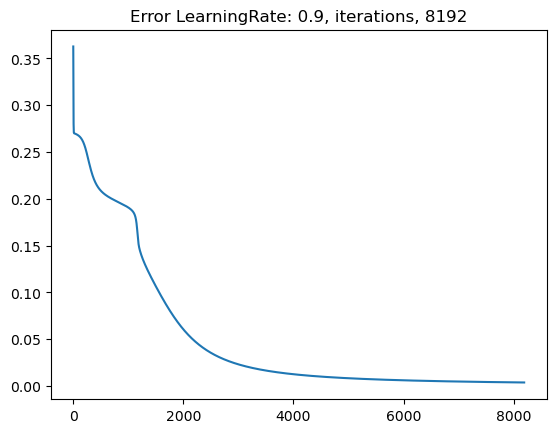

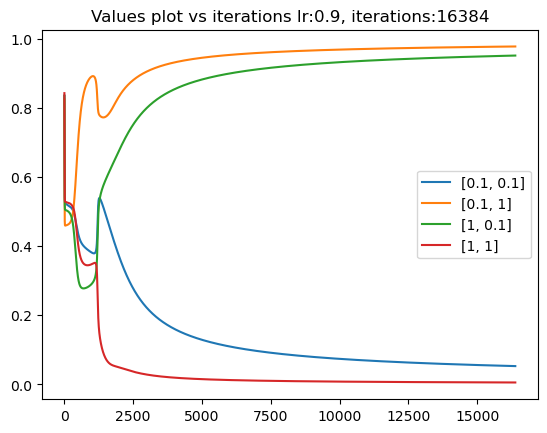

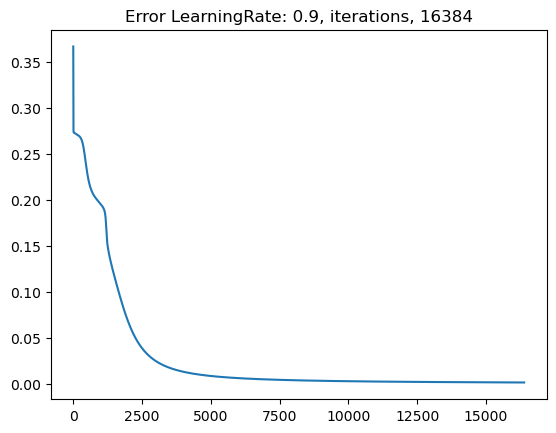

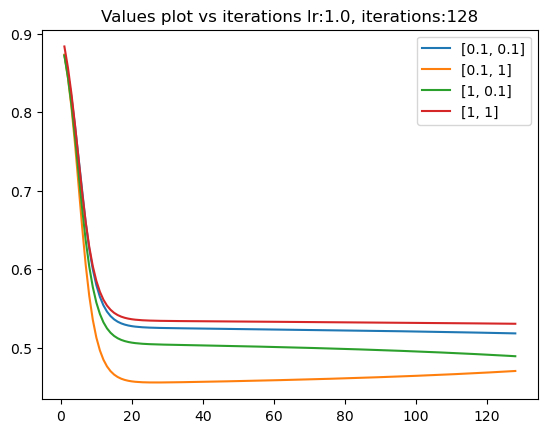

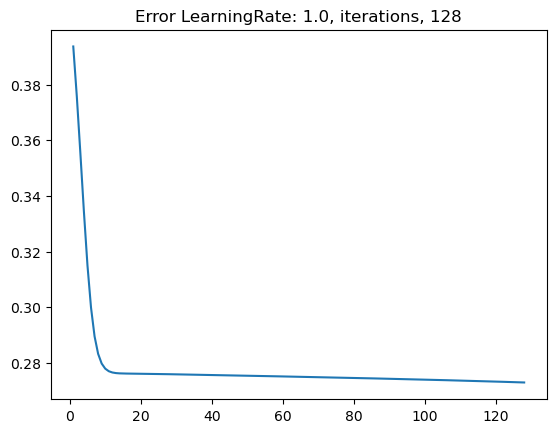

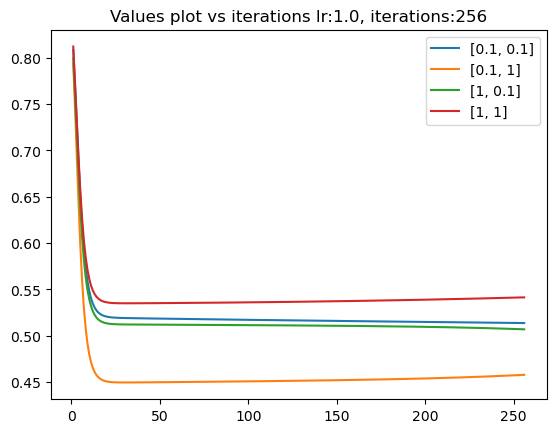

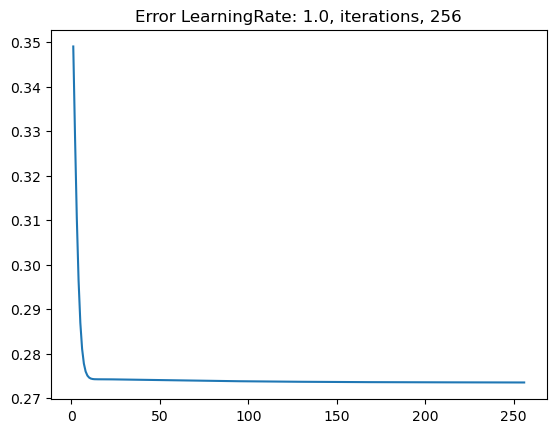

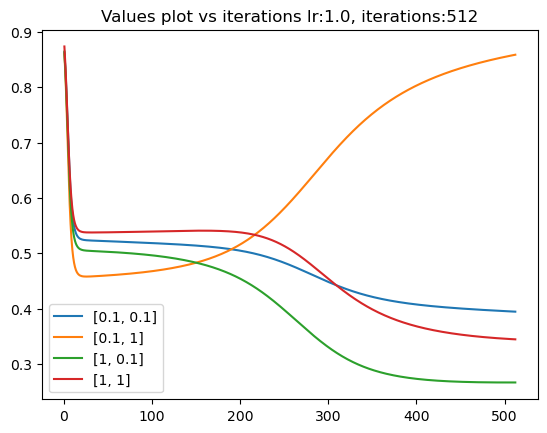

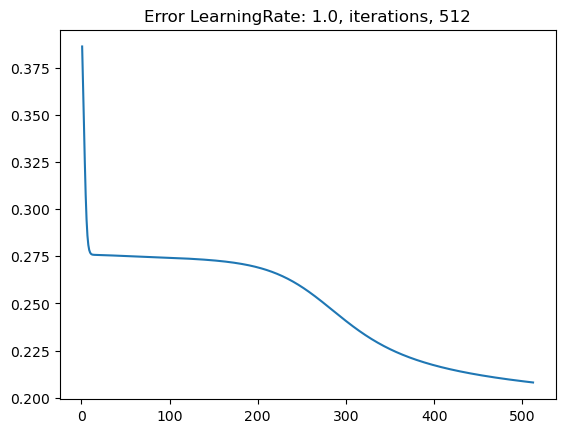

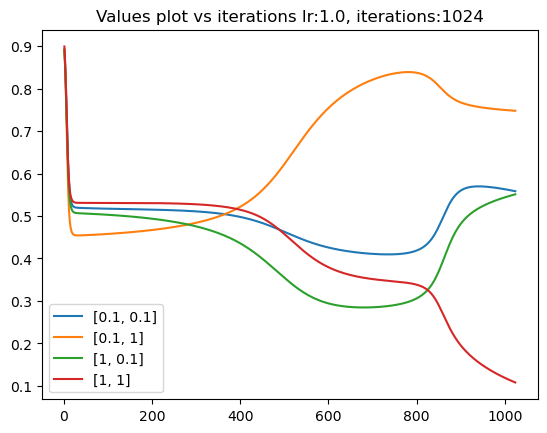

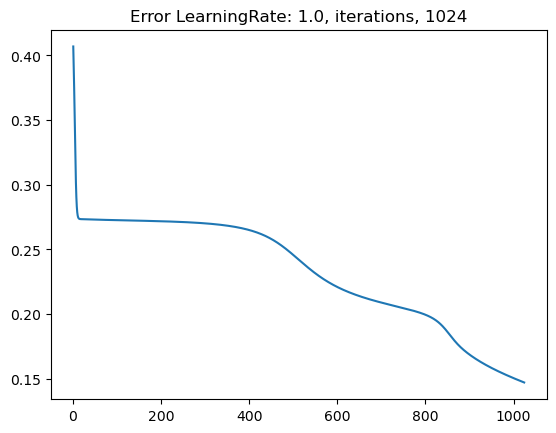

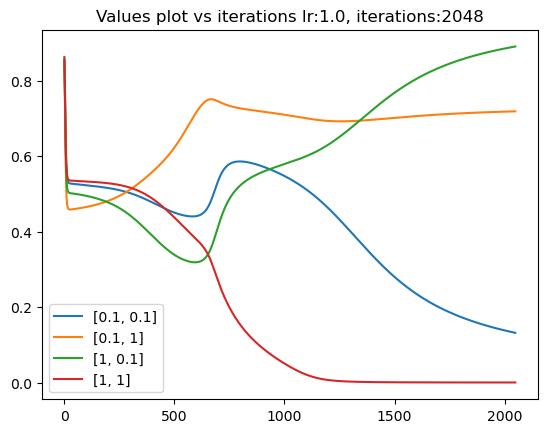

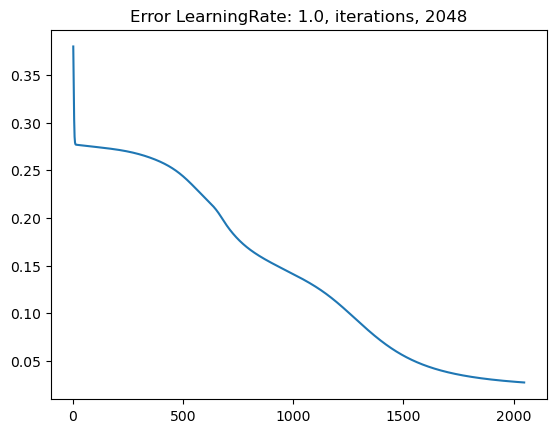

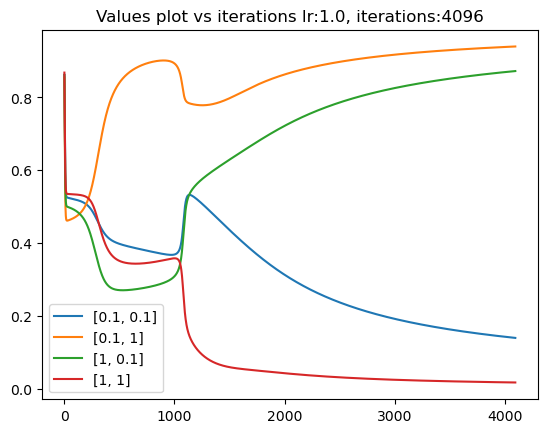

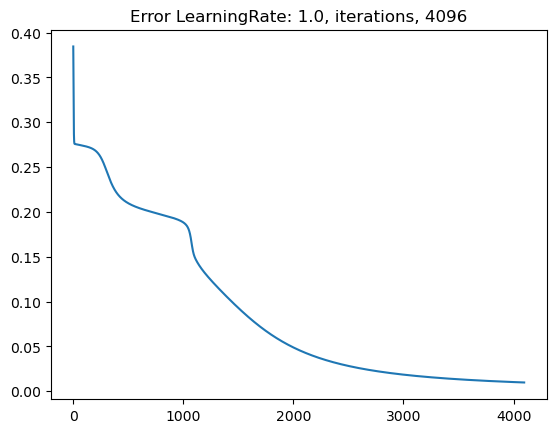

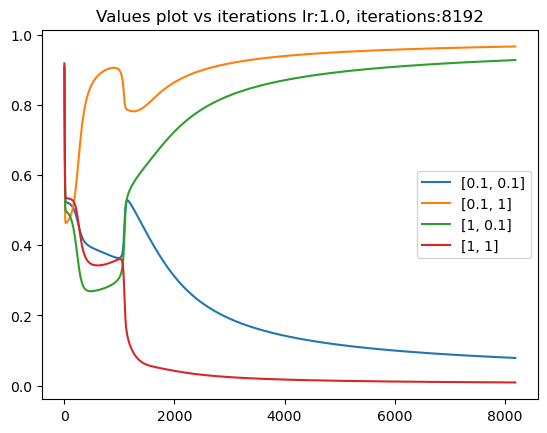

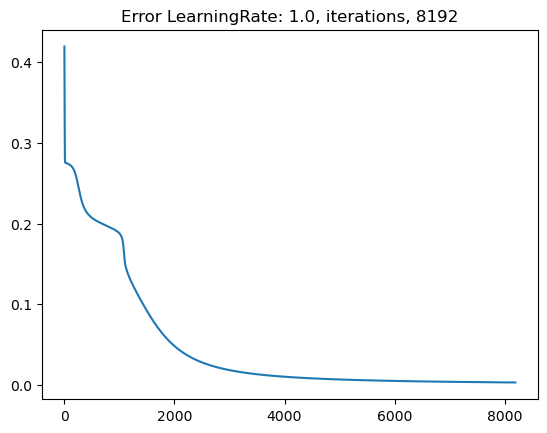

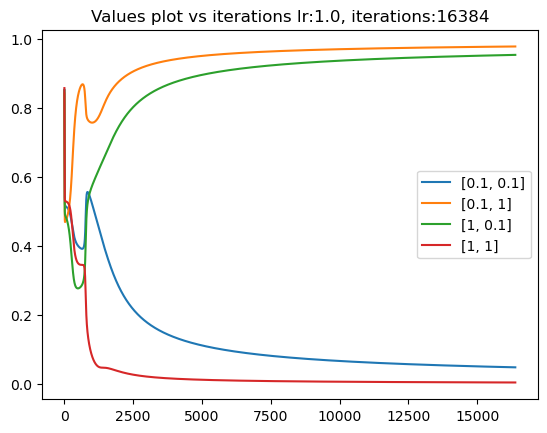

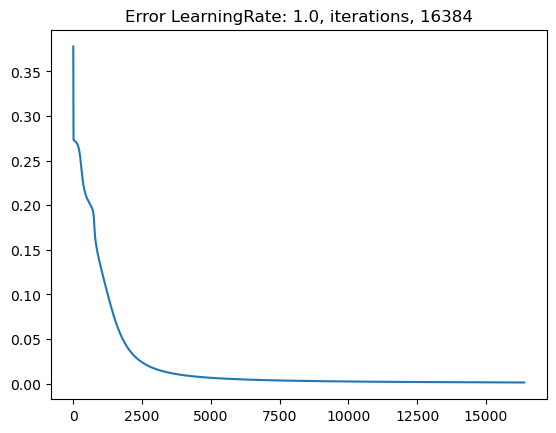

0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
128    0.251760  0.251689  0.250151  0.250811  0.250036  0.250214  0.245967   
256    0.251065  0.251464  0.249875  0.250178  0.248209  0.247913  0.248502   
512    0.249985  0.247526  0.248865  0.248640  0.238764  0.244077  0.243233   
1024   0.250773  0.244847  0.229197  0.238266  0.191768  0.187967  0.209014   
2048   0.250570  0.244677  0.197515  0.195835  0.117040  0.183917  0.086689   
4096   0.216581  0.152790  0.189503  0.084240  0.048664  0.030778  0.021635   
8192   0.182496  0.052144  0.030851  0.016134  0.009459  0.019162  0.018925   
16384  0.073827  0.175698  0.007141  0.004913  0.003133  0.002505  0.001998   

            0.9       1.0  
128    0.249540  0.250577  
256    0.242229  0.250549  
512    0.201011  0.192507  
1024   0.174859  0.135910  
2048   0.043530  0.027000  
4096   0.011421  0.009615  
8192   0.003652  0.003134  
16384  0.001435  0.001232

In [388]:
import pandas as pd

learningRate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
iterations = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
dataset = []
df = pd.DataFrame(columns=learningRate)
for lr in learningRate:
    column = []
    for iteration in iterations:
        error = plotGraphs(lr=lr, iterations=iteration)
        column.append(error)
    df[lr] = column
df.index = iterations
df

In [386]:
df.style.highlight_min(color="teal")
